In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy

import math
import torch
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.nn.modules import LayerNorm, Linear, ReLU
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
from torch.utils.data import DataLoader



device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data Loader

In [159]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy') 
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')


test_size = 20/100
X_pool, X_val, y_pool, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

initial_labeled = 10
initial_labeled= 1-initial_labeled/len(X_pool)
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_pool, y_pool, test_size=initial_labeled, stratify=y_pool, random_state=42)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_labeled shape: {X_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"X_unlabeled shape: {X_unlabeled.shape}")
print(f"y_unlabeled shape: {y_unlabeled.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val  shape: {y_val .shape}")


X shape: (20000, 6, 28)
y shape: (20000,)
X_labeled shape: (10, 6, 28)
y_labeled shape: (10,)
X_unlabeled shape: (15990, 6, 28)
y_unlabeled shape: (15990,)
X_val shape: (4000, 6, 28)
y_val  shape: (4000,)


In [160]:
y_sample = y_val
X_sample = X_val

# Label distribution
label_counts = Counter(y_sample)
df_labels = pd.DataFrame.from_dict(label_counts, orient='index').sort_index()
df_labels.columns = ['count']
df_labels['percent'] = 100 * df_labels['count'] / len(y_sample)
print("\nLabel distribution:")
print(df_labels)

channel_variance = np.var(X_sample, axis=2).mean(axis=0)
channel_mean = X_sample.mean(axis=(0, 2))
channel_std = X_sample.std(axis=(0, 2))
df_stats = pd.DataFrame({
    'channel': range(6),
    'mean': channel_mean,
    'std_dev': channel_std,
    'variance': channel_variance
})
print("\nMean, Std Dev and Variance per Channel:")
print(df_stats)


Label distribution:
   count  percent
0   1816   45.400
1    521   13.025
2   1663   41.575

Mean, Std Dev and Variance per Channel:
   channel      mean   std_dev  variance
0        0  0.009762  0.997754  0.730740
1        1  0.011106  0.995511  0.719789
2        2  0.008543  0.997186  0.755344
3        3  0.008551  0.996257  0.782027
4        4  0.012396  0.999044  0.637619
5        5  0.009685  1.002726  0.733507


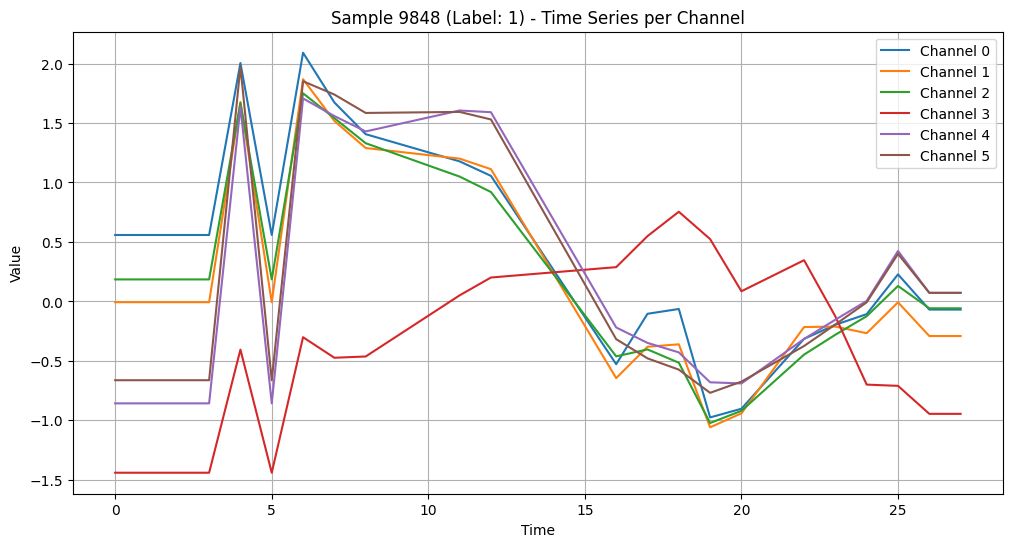

In [161]:
i = np.random.randint(0, len(X))
sample = X[i]  # Shape: (6, T)

plt.figure(figsize=(12, 6))
for c in range(6):
    plt.plot(sample[c], label=f'Channel {c}')
plt.title(f"Sample {i} (Label: {y[i]}) - Time Series per Channel")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Dataloader

In [162]:
class Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __getitem__(self, index):
        return {
            "x": self.X[index],  # shape: [C, T]
            "y": self.y[index]
        }

    def __len__(self):
        return len(self.X)

In [163]:
labeled_dataset = Dataset(X_labeled, y_labeled)
unlabeled_dataset = Dataset(X_unlabeled, y_unlabeled)
val_dataset = Dataset(X_val, y_val)

# Model

In [164]:
################ CNN Backbone 
def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
    )
 
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = conv_block(6, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512)
        self.conv5 = conv_block(512, 1024)
        self.global_pool = nn.AdaptiveAvgPool1d((1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x=self.global_pool(x)
        x = x.view(x.size(0), -1)
        return x
 
################ Fully connected network
class FC(nn.Module):
    def __init__(self,input_dim):
        super(FC, self).__init__()
        self.fco = nn.Linear(input_dim, 3)
    def forward(self, x):
        x=self.fco(x)
        return x


class FullModel(nn.Module):
    def __init__(self, backbone, fc):
        super().__init__()
        self.backbone = backbone
        self.fc = fc

    def forward(self, x):
        feat = self.backbone(x)
        out = self.fc(feat)
        return feat, out

# Loading weights

In [165]:
#pretrained weights
map_location=torch.device(device)

backbone = cnn()
fc = FC(1024)

#loading backbone weights
state_dict = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

backbone.load_state_dict(new_state_dict)

#loading fc weights
state_dict = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth', map_location=map_location)
# Remove "module." prefix
new_state_dict = {}
for k, v in state_dict.items():
    new_key = k.replace("module.", "")  # remove module. prefix
    new_state_dict[new_key] = v

fc.load_state_dict(new_state_dict)

model = FullModel(backbone, fc).to(device)

# Train/eval loop

In [166]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        x, y = batch["x"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        _, out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(dataloader.dataset)
    acc = np.mean(np.array(all_preds) == np.array(all_targets))
    f1s = sklearn.metrics.f1_score(all_targets, all_preds, average=None)
    return avg_loss, acc, f1s, np.mean(f1s)



def _eval_perf(model, dataloader, device, criterion=None):
    model.eval()
    pred, gt = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch["x"].to(device), batch["y"].to(device)
            _, outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            if criterion:
                total_loss += criterion(outputs, y).item() * len(x)

            pred.extend(preds.cpu().numpy())
            gt.extend(y.cpu().numpy())

    acc = np.mean(np.array(pred) == np.array(gt))
    f1s = sklearn.metrics.f1_score(gt, pred, average=None)
    avg_f1 = np.mean(f1s)

    if criterion:
        avg_loss = total_loss / len(dataloader.dataset)
        return avg_loss, f1s, acc, avg_f1
    else:
        return 0, f1s, acc, avg_f1



# Active Learning methods

In [167]:
def plot_round_metrics(history):
    round_id = len(history["epoch_metrics"]) - 1
    epoch_stats = history["epoch_metrics"][round_id]
    epochs = list(range(1, len(epoch_stats) + 1))

    train_loss = [e["train_loss"] for e in epoch_stats]
    val_loss = [e["val_loss"] for e in epoch_stats]
    train_acc = [e["train_acc"] for e in epoch_stats]
    train_f1 = [e["train_avg_f1"] for e in epoch_stats]
    val_acc = [e["val_acc"] for e in epoch_stats]
    val_f1 = [e["val_avg_f1"] for e in epoch_stats]

    plt.figure(figsize=(15, 4))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"[Round {round_id+1}] Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"[Round {round_id+1}] Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Avg F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1, label="Val F1")
    plt.title(f"[Round {round_id+1}] Avg F1")
    plt.xlabel("Epoch")
    plt.ylabel("Avg F1")
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_final_performance(history):
    samples = history["samples"]
    val_acc = history["round_val_acc"]
    val_f1 = history["round_val_avg_f1"]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(samples, val_acc, marker='o')
    plt.title("Val Accuracy vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(samples, val_f1, marker='o')
    plt.title("Val Avg F1 vs Labeled Samples")
    plt.xlabel("Labeled Samples")
    plt.ylabel("Avg F1")

    plt.tight_layout()
    plt.show()


In [168]:
def query_samples(model, dataset, query_size, strategy, device):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=128)
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            x = batch["x"].to(device)
            _, out = model(x)
            probs = F.softmax(out, dim=1)

            if strategy == "entropy":
                score = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
            elif strategy == "least_confident":
                score = 1 - probs.max(dim=1)[0]
            elif strategy == "margin":
                sorted_probs, _ = probs.sort(dim=1, descending=True)
                score = sorted_probs[:, 0] - sorted_probs[:, 1]
                score = -score
            elif strategy == "random":
                score = torch.rand(len(x), device=device)
            else:
                raise ValueError(f"Unknown strategy {strategy}")
            
            all_scores.extend(score.cpu().numpy())

    indices = np.argsort(all_scores)[-query_size:]
    return indices


# Active Learning Loop

In [169]:
def active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy, device, iters=10, query_size=100, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    history = {
        "strategy": strategy,
        "samples": [],  # number of labeled samples after each AL round
        "epoch_metrics": [],  # stores list of dicts per epoch for each AL round
        "round_val_acc": [],
        "round_val_avg_f1": []
    }


    for it in range(iters):
        print(f"\n[AL Round {it+1}/{iters}] — Labeled samples: {len(labeled_dataset)}")

        train_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64)

        epoch_stats = []

        for ep in range(epochs):
            print(f"\nEpoch {ep+1}/{epochs}")
            tr_loss, tr_acc, tr_f1s, tr_avgf1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_f1s, val_acc, val_avgf1 = _eval_perf(model, val_loader, device, criterion)
        
            print(f"Train — Loss: {tr_loss:.4f} | Acc: {tr_acc:.4f} | Avg F1: {tr_avgf1:.4f}")
            print(f"Val   — Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Avg F1: {val_avgf1:.4f}")
        
            epoch_stats.append({
                "train_loss": tr_loss,
                "train_acc": tr_acc,
                "train_avg_f1": tr_avgf1,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_avg_f1": val_avgf1
            })

        
        # Save per-round stats
        history["samples"].append(len(labeled_dataset))
        history["epoch_metrics"].append(epoch_stats)
        history["round_val_acc"].append(val_acc)
        history["round_val_avg_f1"].append(val_avgf1)


        # Query next samples
        if len(unlabeled_dataset) < query_size:
            print("Unlabeled pool exhausted.")
            break

        selected_idxs = query_samples(model, unlabeled_dataset, query_size, strategy, device)

        new_x = [unlabeled_dataset.X[i] for i in selected_idxs]
        new_y = [unlabeled_dataset.y[i] for i in selected_idxs]

        labeled_dataset.X = torch.cat([labeled_dataset.X, torch.stack(new_x)], dim=0)
        labeled_dataset.y = torch.cat([labeled_dataset.y, torch.tensor(new_y)], dim=0)

        keep_idxs = list(set(range(len(unlabeled_dataset))) - set(selected_idxs))
        unlabeled_dataset.X = torch.stack([unlabeled_dataset.X[i] for i in keep_idxs])
        unlabeled_dataset.y = torch.tensor([unlabeled_dataset.y[i] for i in keep_idxs])

        # Plot current round
        plot_round_metrics(history)

    plot_final_performance(history)
    return history



[AL Round 1/60] — Labeled samples: 10

Epoch 1/7


Train — Loss: 6.5435 | Acc: 0.4000 | Avg F1: 0.3810
Val   — Loss: 2.0816 | Acc: 0.5295 | Avg F1: 0.5195

Epoch 2/7


Train — Loss: 2.8880 | Acc: 0.4000 | Avg F1: 0.4167
Val   — Loss: 2.1046 | Acc: 0.4830 | Avg F1: 0.4778

Epoch 3/7


Train — Loss: 0.9503 | Acc: 0.8000 | Avg F1: 0.7500
Val   — Loss: 2.5240 | Acc: 0.4210 | Avg F1: 0.4197

Epoch 4/7


Train — Loss: 0.0937 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 3.0267 | Acc: 0.3762 | Avg F1: 0.3736

Epoch 5/7


Train — Loss: 0.0371 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 3.5212 | Acc: 0.3320 | Avg F1: 0.3263

Epoch 6/7


Train — Loss: 0.0205 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 3.9829 | Acc: 0.3030 | Avg F1: 0.2949

Epoch 7/7


Train — Loss: 0.0096 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 4.3885 | Acc: 0.2863 | Avg F1: 0.2760


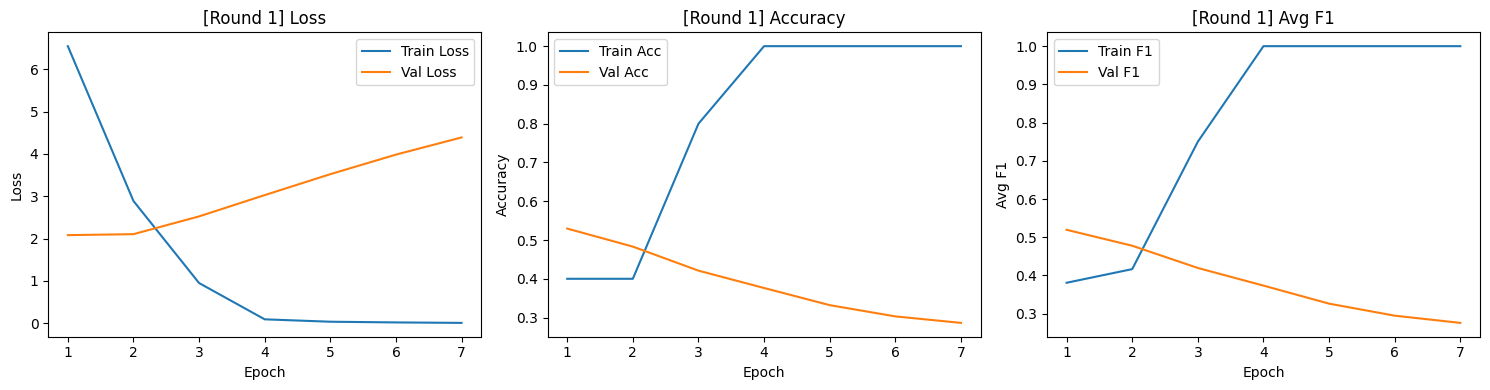


[AL Round 2/60] — Labeled samples: 20

Epoch 1/7


Train — Loss: 0.9107 | Acc: 0.5500 | Avg F1: 0.5082
Val   — Loss: 4.8546 | Acc: 0.2782 | Avg F1: 0.2643

Epoch 2/7


Train — Loss: 0.4992 | Acc: 0.8000 | Avg F1: 0.7063
Val   — Loss: 5.3349 | Acc: 0.2685 | Avg F1: 0.2518

Epoch 3/7


Train — Loss: 0.1822 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 5.8401 | Acc: 0.2635 | Avg F1: 0.2457

Epoch 4/7


Train — Loss: 0.0740 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 6.3378 | Acc: 0.2552 | Avg F1: 0.2362

Epoch 5/7


Train — Loss: 0.0404 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 6.7932 | Acc: 0.2492 | Avg F1: 0.2299

Epoch 6/7


Train — Loss: 0.0246 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 7.1855 | Acc: 0.2472 | Avg F1: 0.2277

Epoch 7/7


Train — Loss: 0.0161 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 7.5051 | Acc: 0.2475 | Avg F1: 0.2285


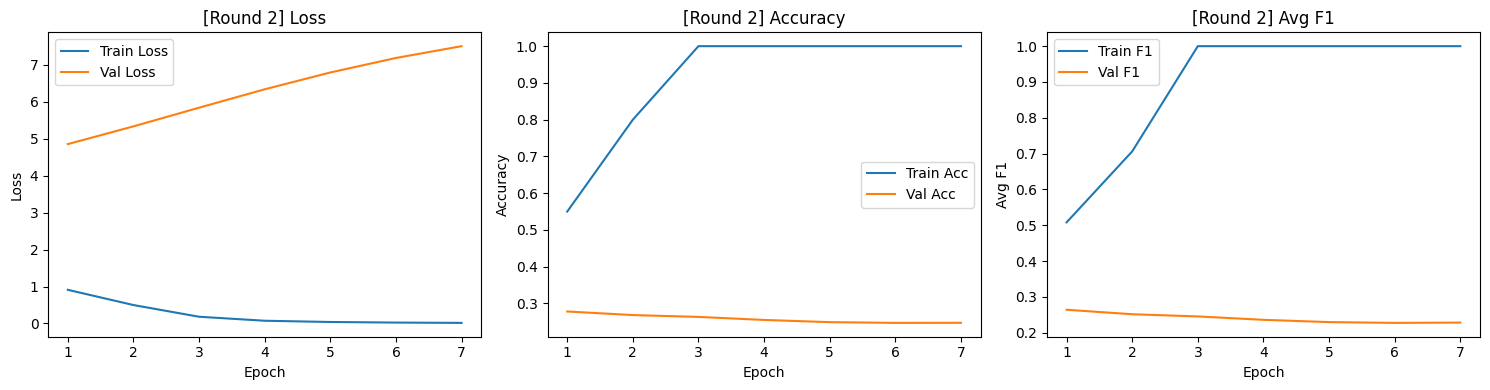


[AL Round 3/60] — Labeled samples: 30

Epoch 1/7


Train — Loss: 0.9579 | Acc: 0.7000 | Avg F1: 0.6085
Val   — Loss: 7.7083 | Acc: 0.2515 | Avg F1: 0.2334

Epoch 2/7


Train — Loss: 0.6183 | Acc: 0.7000 | Avg F1: 0.6085
Val   — Loss: 7.8309 | Acc: 0.2527 | Avg F1: 0.2344

Epoch 3/7


Train — Loss: 0.3035 | Acc: 0.8333 | Avg F1: 0.7185
Val   — Loss: 8.1010 | Acc: 0.2527 | Avg F1: 0.2347

Epoch 4/7


Train — Loss: 0.1800 | Acc: 0.9333 | Avg F1: 0.8547
Val   — Loss: 8.5383 | Acc: 0.2495 | Avg F1: 0.2310

Epoch 5/7


Train — Loss: 0.1063 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 9.0520 | Acc: 0.2447 | Avg F1: 0.2259

Epoch 6/7


Train — Loss: 0.0609 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 9.5544 | Acc: 0.2385 | Avg F1: 0.2190

Epoch 7/7


Train — Loss: 0.0382 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 9.9926 | Acc: 0.2340 | Avg F1: 0.2140


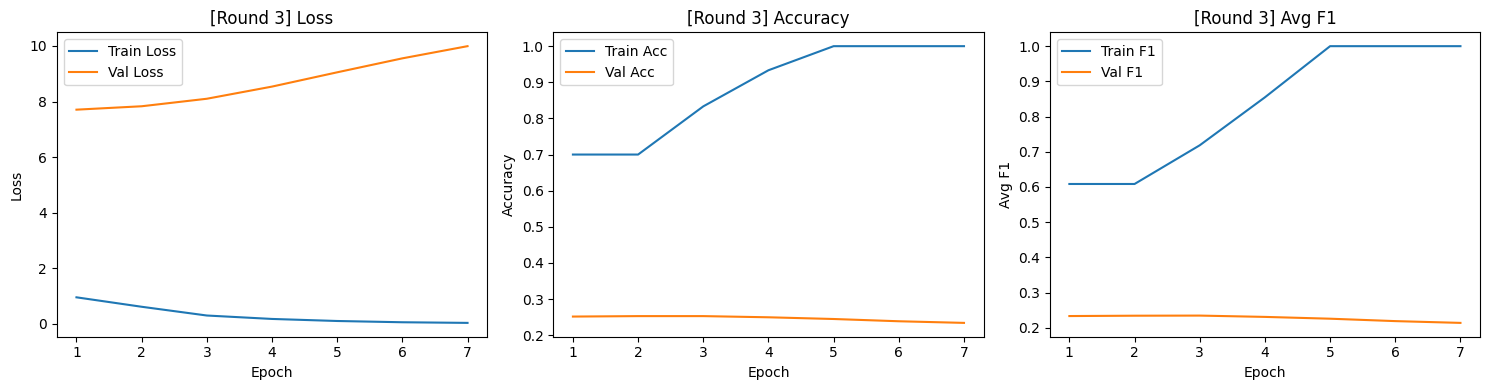


[AL Round 4/60] — Labeled samples: 40

Epoch 1/7


Train — Loss: 0.4138 | Acc: 0.8000 | Avg F1: 0.7105
Val   — Loss: 10.3449 | Acc: 0.2295 | Avg F1: 0.2099

Epoch 2/7


Train — Loss: 0.3415 | Acc: 0.8500 | Avg F1: 0.7938
Val   — Loss: 10.5209 | Acc: 0.2273 | Avg F1: 0.2087

Epoch 3/7


Train — Loss: 0.2299 | Acc: 0.9250 | Avg F1: 0.8460
Val   — Loss: 10.6112 | Acc: 0.2275 | Avg F1: 0.2125

Epoch 4/7


Train — Loss: 0.1276 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.6617 | Acc: 0.2305 | Avg F1: 0.2185

Epoch 5/7


Train — Loss: 0.0671 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.6778 | Acc: 0.2385 | Avg F1: 0.2304

Epoch 6/7


Train — Loss: 0.0400 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.6543 | Acc: 0.2450 | Avg F1: 0.2392

Epoch 7/7


Train — Loss: 0.0271 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.5932 | Acc: 0.2545 | Avg F1: 0.2514


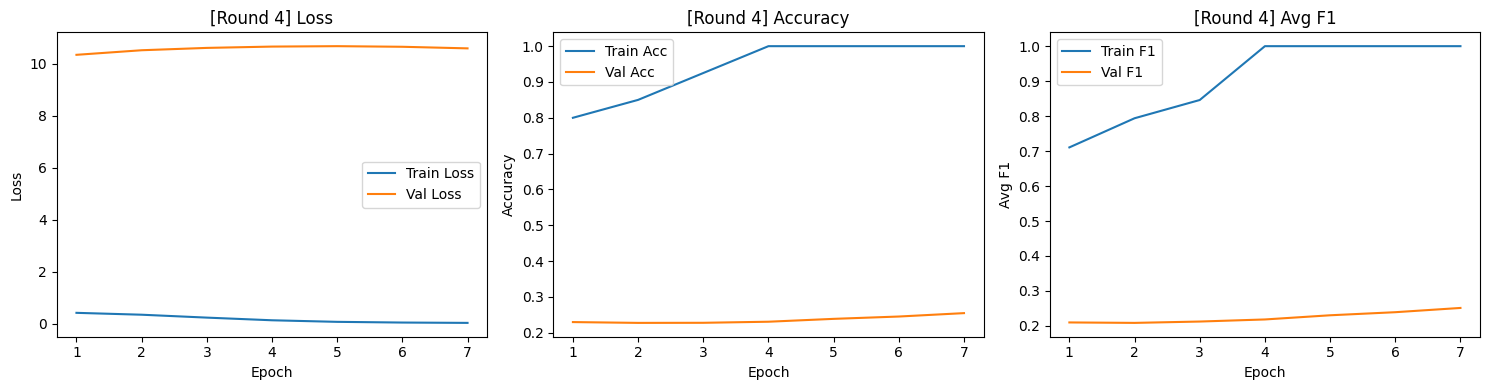


[AL Round 5/60] — Labeled samples: 50

Epoch 1/7


Train — Loss: 0.3274 | Acc: 0.8600 | Avg F1: 0.7967
Val   — Loss: 10.6271 | Acc: 0.2592 | Avg F1: 0.2573

Epoch 2/7


Train — Loss: 0.2322 | Acc: 0.9400 | Avg F1: 0.8540
Val   — Loss: 10.6564 | Acc: 0.2620 | Avg F1: 0.2607

Epoch 3/7


Train — Loss: 0.1435 | Acc: 0.9400 | Avg F1: 0.8540
Val   — Loss: 10.6868 | Acc: 0.2595 | Avg F1: 0.2578

Epoch 4/7


Train — Loss: 0.0834 | Acc: 0.9800 | Avg F1: 0.9853
Val   — Loss: 10.7323 | Acc: 0.2615 | Avg F1: 0.2603

Epoch 5/7


Train — Loss: 0.0476 | Acc: 0.9800 | Avg F1: 0.9243
Val   — Loss: 10.7942 | Acc: 0.2590 | Avg F1: 0.2571

Epoch 6/7


Train — Loss: 0.0279 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.8621 | Acc: 0.2590 | Avg F1: 0.2571

Epoch 7/7


Train — Loss: 0.0175 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 10.9235 | Acc: 0.2592 | Avg F1: 0.2573


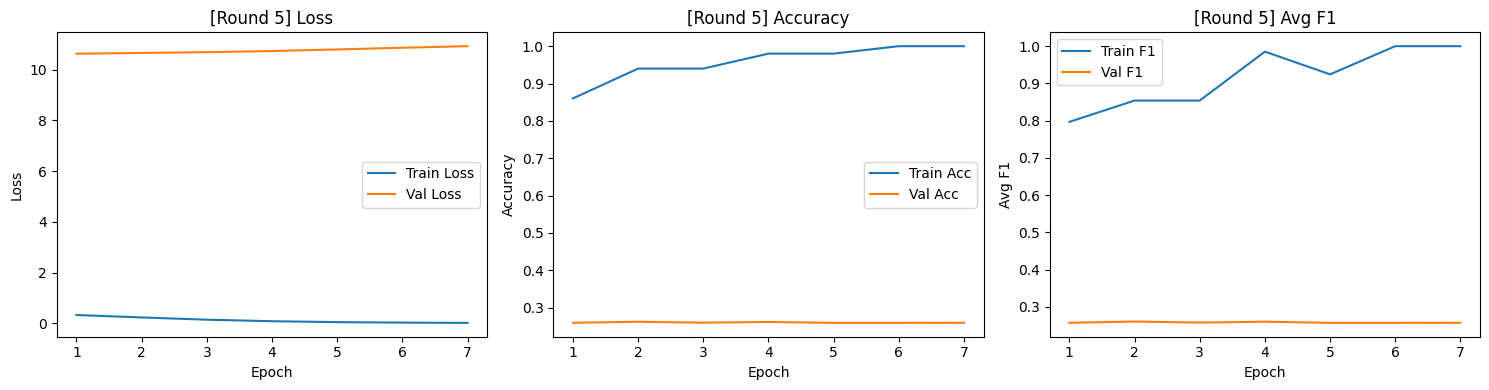


[AL Round 6/60] — Labeled samples: 60

Epoch 1/7


Train — Loss: 0.0925 | Acc: 0.9667 | Avg F1: 0.9160
Val   — Loss: 11.1202 | Acc: 0.2570 | Avg F1: 0.2546

Epoch 2/7


Train — Loss: 0.0767 | Acc: 0.9833 | Avg F1: 0.9871
Val   — Loss: 11.3244 | Acc: 0.2542 | Avg F1: 0.2510

Epoch 3/7


Train — Loss: 0.0624 | Acc: 0.9833 | Avg F1: 0.9871
Val   — Loss: 11.5243 | Acc: 0.2525 | Avg F1: 0.2485

Epoch 4/7


Train — Loss: 0.0457 | Acc: 0.9833 | Avg F1: 0.9871
Val   — Loss: 11.7095 | Acc: 0.2490 | Avg F1: 0.2439

Epoch 5/7


Train — Loss: 0.0307 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 11.8695 | Acc: 0.2480 | Avg F1: 0.2423

Epoch 6/7


Train — Loss: 0.0208 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 11.9976 | Acc: 0.2467 | Avg F1: 0.2408

Epoch 7/7


Train — Loss: 0.0149 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 12.0922 | Acc: 0.2475 | Avg F1: 0.2416


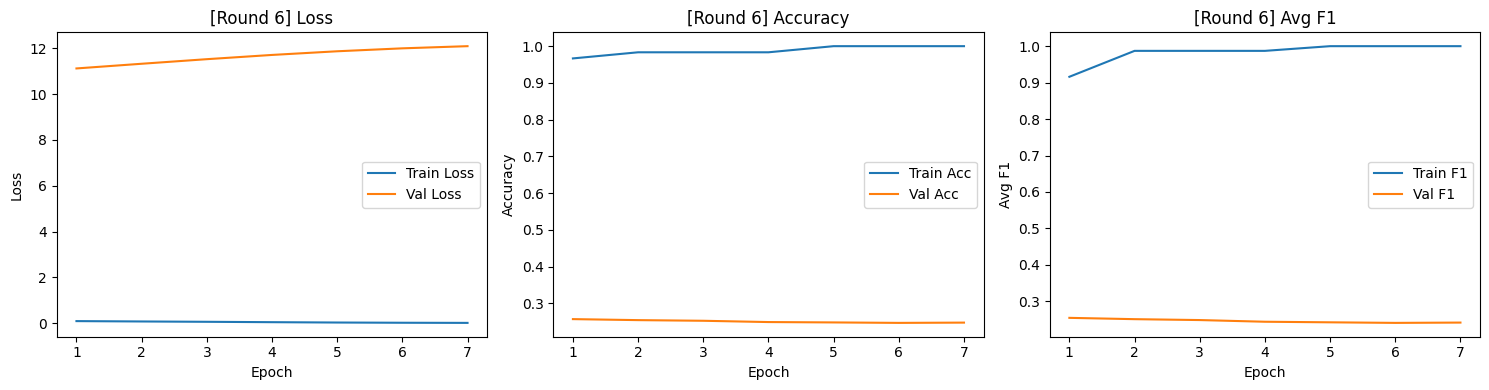


[AL Round 7/60] — Labeled samples: 70

Epoch 1/7


Train — Loss: 0.5310 | Acc: 0.9143 | Avg F1: 0.8372
Val   — Loss: 12.1444 | Acc: 0.2667 | Avg F1: 0.2664

Epoch 2/7


Train — Loss: 0.1135 | Acc: 0.9571 | Avg F1: 0.9675
Val   — Loss: 11.1829 | Acc: 0.3083 | Avg F1: 0.3138

Epoch 3/7


Train — Loss: 0.2260 | Acc: 0.9286 | Avg F1: 0.8864
Val   — Loss: 9.6353 | Acc: 0.3770 | Avg F1: 0.3853

Epoch 4/7


Train — Loss: 0.6051 | Acc: 0.9000 | Avg F1: 0.7654
Val   — Loss: 8.6381 | Acc: 0.4412 | Avg F1: 0.4428

Epoch 5/7


Train — Loss: 0.1550 | Acc: 0.9286 | Avg F1: 0.8030
Val   — Loss: 8.6267 | Acc: 0.4637 | Avg F1: 0.4589

Epoch 6/7


Train — Loss: 0.0807 | Acc: 0.9857 | Avg F1: 0.9889
Val   — Loss: 8.7259 | Acc: 0.4605 | Avg F1: 0.4528

Epoch 7/7


Train — Loss: 0.1782 | Acc: 0.9714 | Avg F1: 0.8815
Val   — Loss: 8.9228 | Acc: 0.4790 | Avg F1: 0.4619


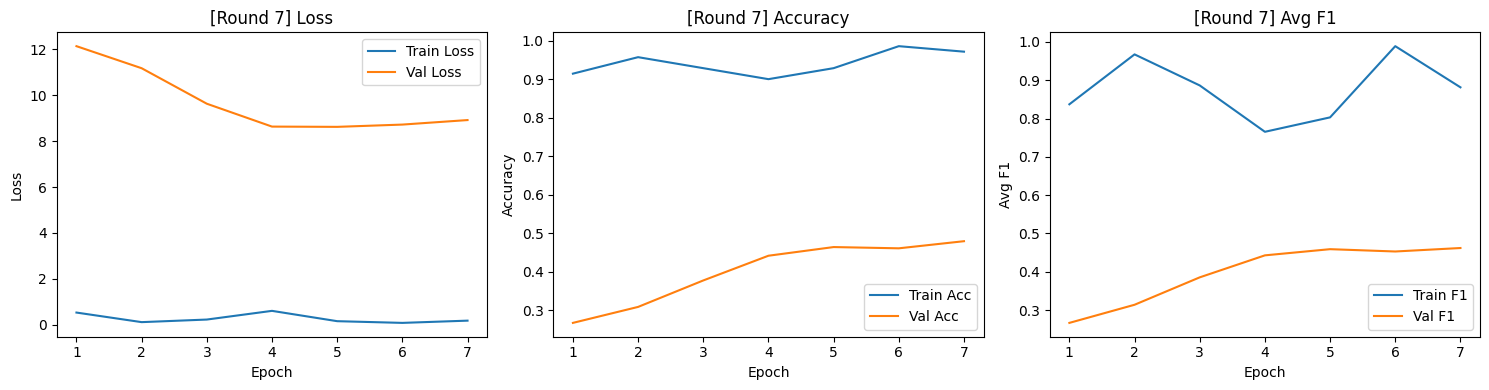


[AL Round 8/60] — Labeled samples: 80

Epoch 1/7


Train — Loss: 0.3156 | Acc: 0.8375 | Avg F1: 0.6929
Val   — Loss: 8.0041 | Acc: 0.5205 | Avg F1: 0.4956

Epoch 2/7


Train — Loss: 0.3897 | Acc: 0.8875 | Avg F1: 0.7443
Val   — Loss: 7.2375 | Acc: 0.5447 | Avg F1: 0.5234

Epoch 3/7


Train — Loss: 0.3783 | Acc: 0.8625 | Avg F1: 0.7184
Val   — Loss: 6.9987 | Acc: 0.5570 | Avg F1: 0.5349

Epoch 4/7


Train — Loss: 0.2449 | Acc: 0.9000 | Avg F1: 0.7521
Val   — Loss: 6.6733 | Acc: 0.5730 | Avg F1: 0.5506

Epoch 5/7


Train — Loss: 0.1304 | Acc: 0.9625 | Avg F1: 0.8480
Val   — Loss: 5.9759 | Acc: 0.5863 | Avg F1: 0.5673

Epoch 6/7


Train — Loss: 0.0590 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 5.1043 | Acc: 0.6120 | Avg F1: 0.5944

Epoch 7/7


Train — Loss: 0.1530 | Acc: 0.9375 | Avg F1: 0.8103
Val   — Loss: 4.5939 | Acc: 0.6195 | Avg F1: 0.6041


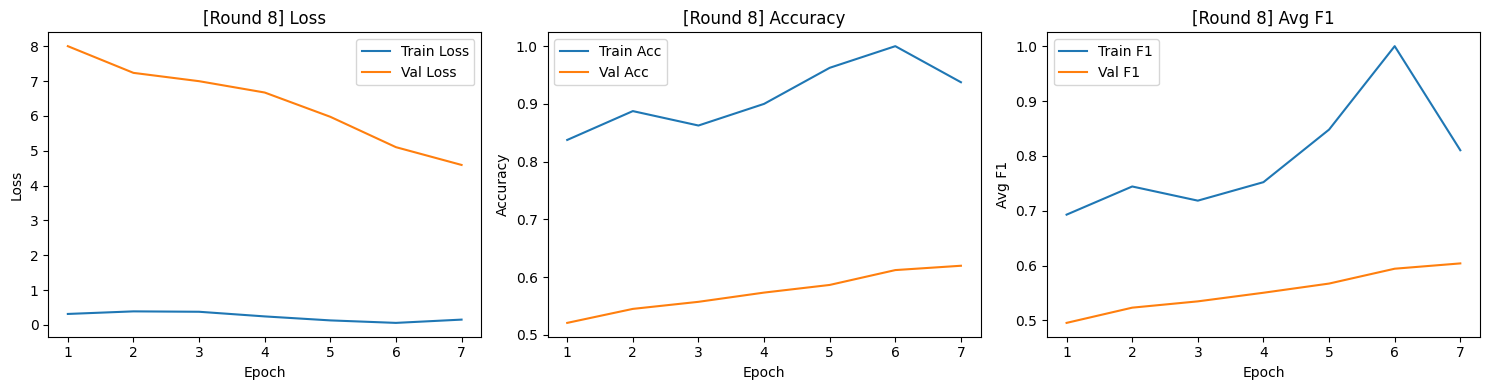


[AL Round 9/60] — Labeled samples: 90

Epoch 1/7


Train — Loss: 0.5245 | Acc: 0.8889 | Avg F1: 0.7546
Val   — Loss: 3.8206 | Acc: 0.6550 | Avg F1: 0.6376

Epoch 2/7


Train — Loss: 0.2535 | Acc: 0.9111 | Avg F1: 0.7867
Val   — Loss: 3.0376 | Acc: 0.7095 | Avg F1: 0.6931

Epoch 3/7


Train — Loss: 0.2022 | Acc: 0.9333 | Avg F1: 0.7836
Val   — Loss: 2.7033 | Acc: 0.7278 | Avg F1: 0.7163

Epoch 4/7


Train — Loss: 0.1509 | Acc: 0.9556 | Avg F1: 0.8557
Val   — Loss: 2.8086 | Acc: 0.7315 | Avg F1: 0.7207

Epoch 5/7


Train — Loss: 0.1435 | Acc: 0.9444 | Avg F1: 0.8347
Val   — Loss: 3.0793 | Acc: 0.7220 | Avg F1: 0.7095

Epoch 6/7


Train — Loss: 0.0475 | Acc: 0.9889 | Avg F1: 0.9497
Val   — Loss: 3.2697 | Acc: 0.7095 | Avg F1: 0.6958

Epoch 7/7


Train — Loss: 0.0705 | Acc: 0.9778 | Avg F1: 0.9402
Val   — Loss: 3.2940 | Acc: 0.7083 | Avg F1: 0.6936


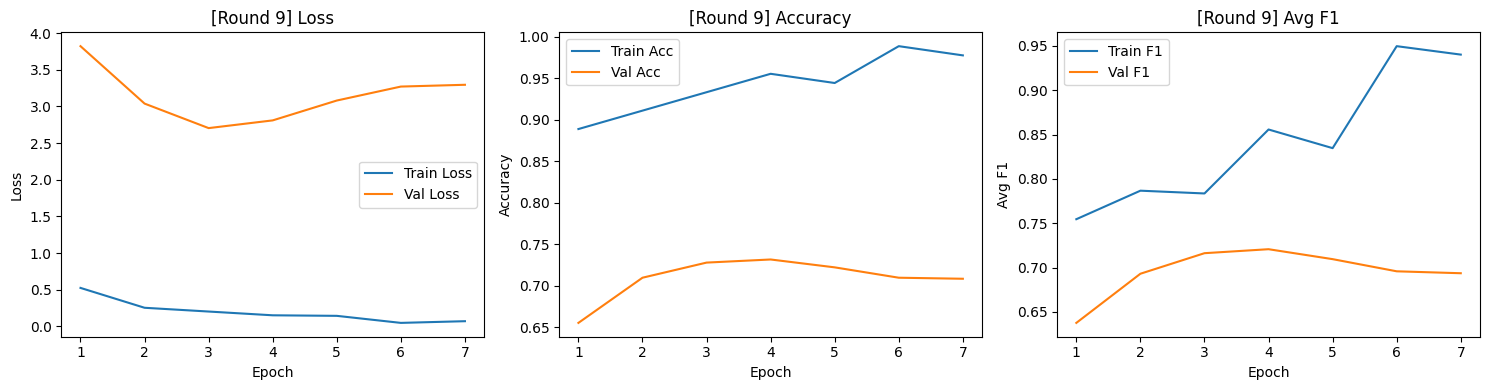


[AL Round 10/60] — Labeled samples: 100

Epoch 1/7


Train — Loss: 0.3637 | Acc: 0.8900 | Avg F1: 0.7655
Val   — Loss: 2.9883 | Acc: 0.7137 | Avg F1: 0.6982

Epoch 2/7


Train — Loss: 0.2071 | Acc: 0.9300 | Avg F1: 0.8049
Val   — Loss: 2.5446 | Acc: 0.7192 | Avg F1: 0.7043

Epoch 3/7


Train — Loss: 0.0991 | Acc: 0.9400 | Avg F1: 0.8323
Val   — Loss: 2.3603 | Acc: 0.7137 | Avg F1: 0.7011

Epoch 4/7


Train — Loss: 0.1003 | Acc: 0.9600 | Avg F1: 0.8865
Val   — Loss: 2.3831 | Acc: 0.6985 | Avg F1: 0.6868

Epoch 5/7


Train — Loss: 0.0514 | Acc: 0.9900 | Avg F1: 0.9573
Val   — Loss: 2.4546 | Acc: 0.6915 | Avg F1: 0.6806

Epoch 6/7


Train — Loss: 0.0645 | Acc: 0.9900 | Avg F1: 0.9604
Val   — Loss: 2.5274 | Acc: 0.6930 | Avg F1: 0.6830

Epoch 7/7


Train — Loss: 0.1827 | Acc: 0.9400 | Avg F1: 0.8413
Val   — Loss: 2.8405 | Acc: 0.6927 | Avg F1: 0.6804


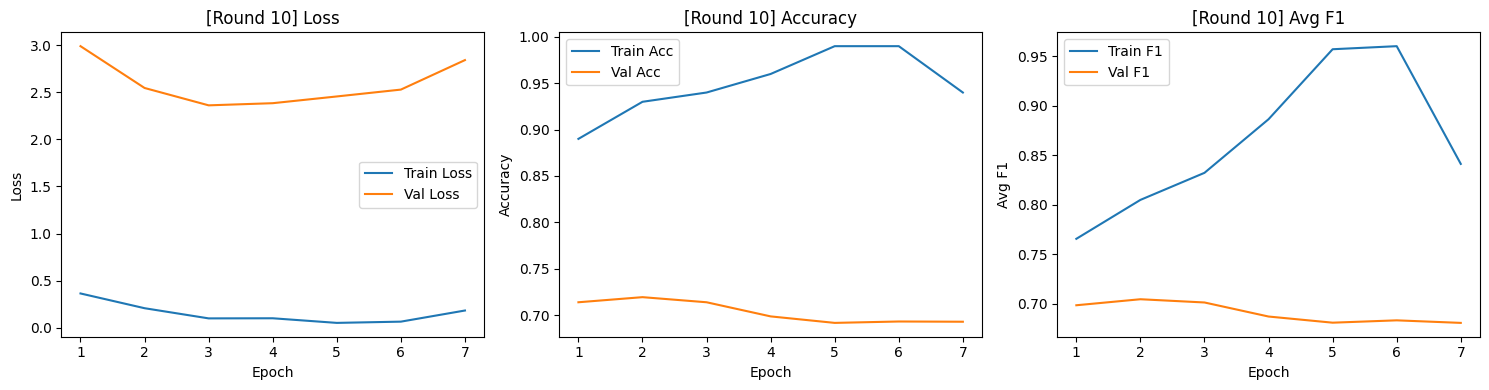


[AL Round 11/60] — Labeled samples: 110

Epoch 1/7


Train — Loss: 0.1210 | Acc: 0.9455 | Avg F1: 0.8750
Val   — Loss: 3.2908 | Acc: 0.6875 | Avg F1: 0.6711

Epoch 2/7


Train — Loss: 0.0738 | Acc: 0.9727 | Avg F1: 0.8969
Val   — Loss: 3.7049 | Acc: 0.6793 | Avg F1: 0.6612

Epoch 3/7


Train — Loss: 0.0712 | Acc: 0.9727 | Avg F1: 0.9528
Val   — Loss: 3.8992 | Acc: 0.6723 | Avg F1: 0.6529

Epoch 4/7


Train — Loss: 0.0597 | Acc: 0.9727 | Avg F1: 0.9296
Val   — Loss: 3.8452 | Acc: 0.6670 | Avg F1: 0.6465

Epoch 5/7


Train — Loss: 0.0313 | Acc: 0.9909 | Avg F1: 0.9927
Val   — Loss: 3.6165 | Acc: 0.6675 | Avg F1: 0.6475

Epoch 6/7


Train — Loss: 0.0762 | Acc: 0.9636 | Avg F1: 0.9251
Val   — Loss: 3.3968 | Acc: 0.6640 | Avg F1: 0.6454

Epoch 7/7


Train — Loss: 0.0261 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 3.2396 | Acc: 0.6510 | Avg F1: 0.6335


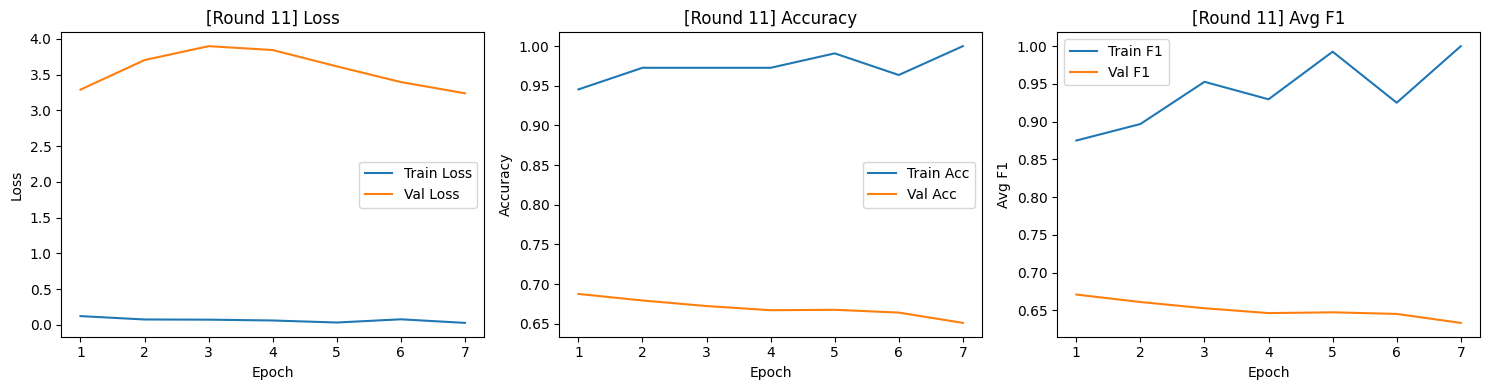


[AL Round 12/60] — Labeled samples: 120

Epoch 1/7


Train — Loss: 0.1145 | Acc: 0.9583 | Avg F1: 0.9679
Val   — Loss: 3.1904 | Acc: 0.6345 | Avg F1: 0.6178

Epoch 2/7


Train — Loss: 0.0846 | Acc: 0.9583 | Avg F1: 0.9206
Val   — Loss: 3.1523 | Acc: 0.6260 | Avg F1: 0.6092

Epoch 3/7


Train — Loss: 0.1060 | Acc: 0.9667 | Avg F1: 0.9479
Val   — Loss: 3.0699 | Acc: 0.6298 | Avg F1: 0.6121

Epoch 4/7


Train — Loss: 0.0212 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 2.9752 | Acc: 0.6405 | Avg F1: 0.6223

Epoch 5/7


Train — Loss: 0.0238 | Acc: 0.9917 | Avg F1: 0.9935
Val   — Loss: 2.9255 | Acc: 0.6488 | Avg F1: 0.6303

Epoch 6/7


Train — Loss: 0.0135 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 2.9014 | Acc: 0.6562 | Avg F1: 0.6382

Epoch 7/7


Train — Loss: 0.0091 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 2.8906 | Acc: 0.6630 | Avg F1: 0.6451


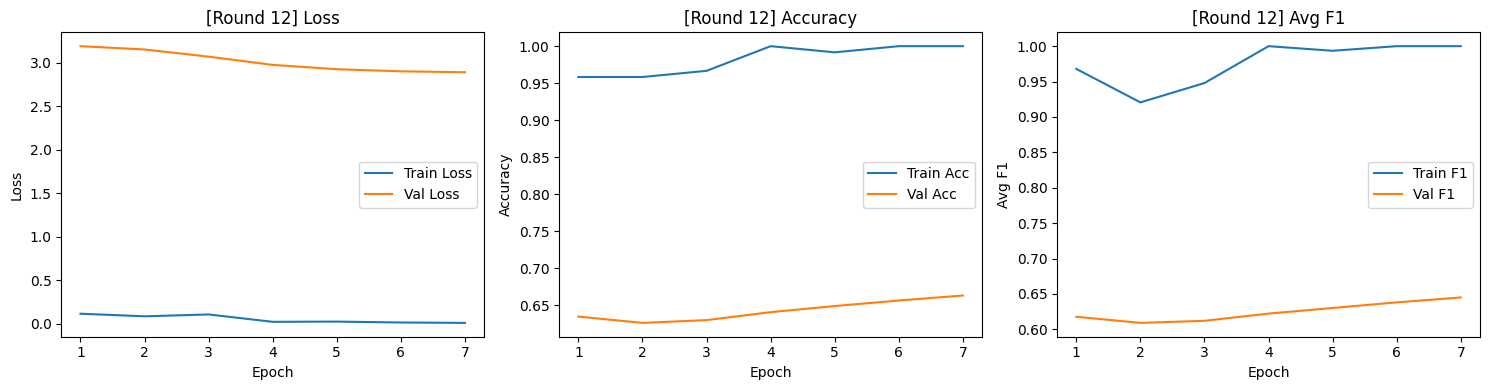


[AL Round 13/60] — Labeled samples: 130

Epoch 1/7


Train — Loss: 0.3012 | Acc: 0.9538 | Avg F1: 0.9366
Val   — Loss: 2.8538 | Acc: 0.6700 | Avg F1: 0.6522

Epoch 2/7


Train — Loss: 0.1144 | Acc: 0.9692 | Avg F1: 0.9545
Val   — Loss: 3.4528 | Acc: 0.5988 | Avg F1: 0.5787

Epoch 3/7


Train — Loss: 0.2258 | Acc: 0.9154 | Avg F1: 0.8375
Val   — Loss: 4.7870 | Acc: 0.4933 | Avg F1: 0.4849

Epoch 4/7


Train — Loss: 0.2118 | Acc: 0.9231 | Avg F1: 0.8556
Val   — Loss: 5.3378 | Acc: 0.5395 | Avg F1: 0.5271

Epoch 5/7


Train — Loss: 0.1302 | Acc: 0.9692 | Avg F1: 0.9211
Val   — Loss: 6.8281 | Acc: 0.5950 | Avg F1: 0.5560

Epoch 6/7


Train — Loss: 0.1421 | Acc: 0.9615 | Avg F1: 0.9304
Val   — Loss: 6.2028 | Acc: 0.6305 | Avg F1: 0.6000

Epoch 7/7


Train — Loss: 0.0958 | Acc: 0.9615 | Avg F1: 0.9442
Val   — Loss: 5.3604 | Acc: 0.6562 | Avg F1: 0.6313


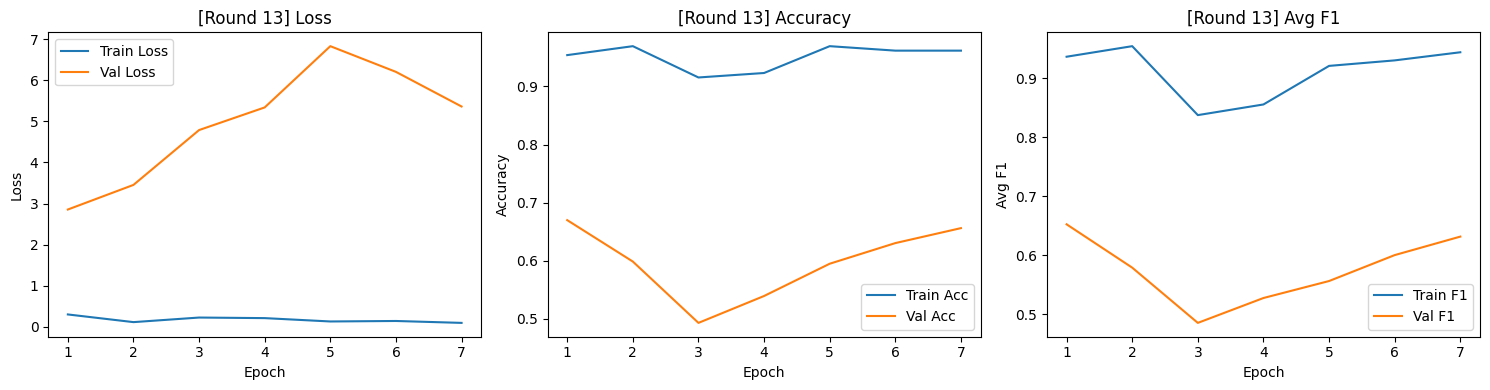


[AL Round 14/60] — Labeled samples: 140

Epoch 1/7


Train — Loss: 0.1691 | Acc: 0.9500 | Avg F1: 0.8628
Val   — Loss: 4.9297 | Acc: 0.6647 | Avg F1: 0.6410

Epoch 2/7


Train — Loss: 0.1228 | Acc: 0.9786 | Avg F1: 0.9566
Val   — Loss: 4.9240 | Acc: 0.6630 | Avg F1: 0.6379

Epoch 3/7


Train — Loss: 0.1922 | Acc: 0.9429 | Avg F1: 0.9065
Val   — Loss: 4.4452 | Acc: 0.6665 | Avg F1: 0.6420

Epoch 4/7


Train — Loss: 0.0504 | Acc: 0.9786 | Avg F1: 0.9828
Val   — Loss: 3.5388 | Acc: 0.6830 | Avg F1: 0.6614

Epoch 5/7


Train — Loss: 0.0635 | Acc: 0.9786 | Avg F1: 0.9828
Val   — Loss: 2.9724 | Acc: 0.6960 | Avg F1: 0.6758

Epoch 6/7


Train — Loss: 0.0920 | Acc: 0.9571 | Avg F1: 0.9414
Val   — Loss: 2.5786 | Acc: 0.7023 | Avg F1: 0.6826

Epoch 7/7


Train — Loss: 0.0539 | Acc: 0.9929 | Avg F1: 0.9943
Val   — Loss: 2.5263 | Acc: 0.7093 | Avg F1: 0.6925


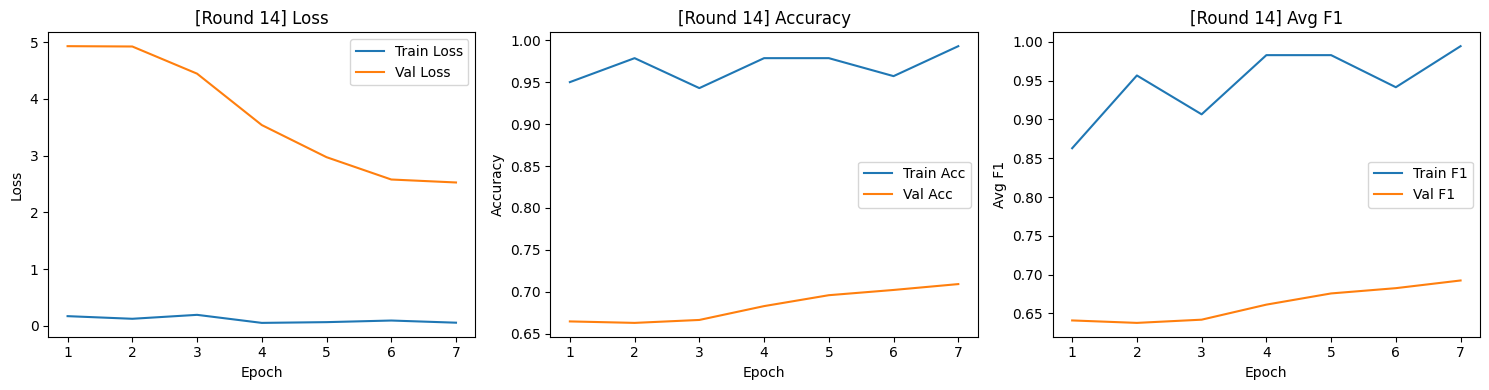


[AL Round 15/60] — Labeled samples: 150

Epoch 1/7


Train — Loss: 0.1873 | Acc: 0.9333 | Avg F1: 0.8877
Val   — Loss: 2.4233 | Acc: 0.7225 | Avg F1: 0.7112

Epoch 2/7


Train — Loss: 0.1528 | Acc: 0.9600 | Avg F1: 0.9691
Val   — Loss: 2.3746 | Acc: 0.7385 | Avg F1: 0.7304

Epoch 3/7


Train — Loss: 0.0504 | Acc: 0.9933 | Avg F1: 0.9948
Val   — Loss: 2.2892 | Acc: 0.7445 | Avg F1: 0.7366

Epoch 4/7


Train — Loss: 0.0764 | Acc: 0.9600 | Avg F1: 0.9461
Val   — Loss: 2.1331 | Acc: 0.7498 | Avg F1: 0.7416

Epoch 5/7


Train — Loss: 0.0274 | Acc: 0.9933 | Avg F1: 0.9948
Val   — Loss: 2.0359 | Acc: 0.7538 | Avg F1: 0.7436

Epoch 6/7


Train — Loss: 0.0174 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.9561 | Acc: 0.7572 | Avg F1: 0.7465

Epoch 7/7


Train — Loss: 0.0200 | Acc: 0.9933 | Avg F1: 0.9948
Val   — Loss: 1.9379 | Acc: 0.7582 | Avg F1: 0.7473


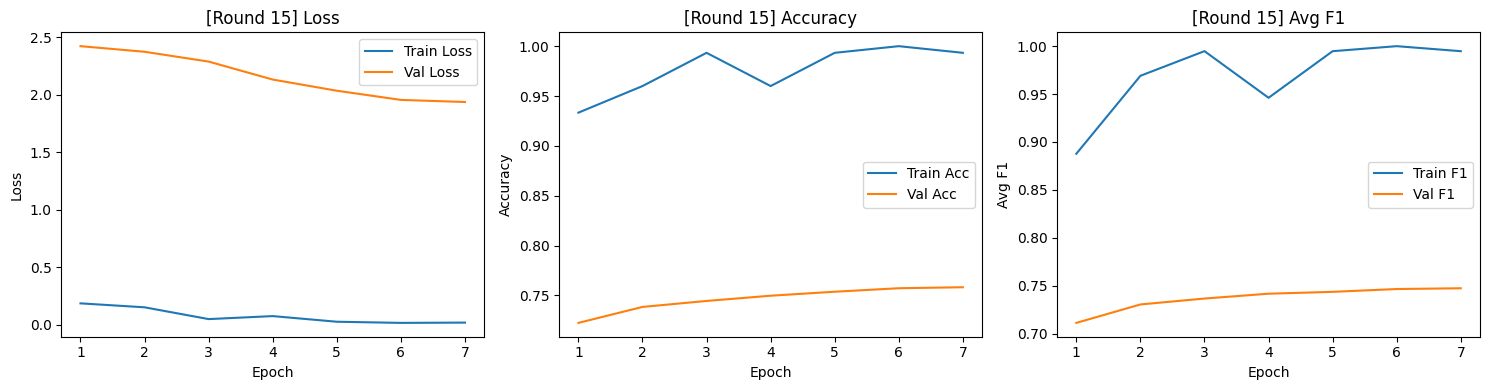


[AL Round 16/60] — Labeled samples: 160

Epoch 1/7


Train — Loss: 0.1511 | Acc: 0.9625 | Avg F1: 0.9293
Val   — Loss: 1.9108 | Acc: 0.7615 | Avg F1: 0.7517

Epoch 2/7


Train — Loss: 0.1032 | Acc: 0.9625 | Avg F1: 0.9484
Val   — Loss: 1.7688 | Acc: 0.7695 | Avg F1: 0.7597

Epoch 3/7


Train — Loss: 0.0277 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.7284 | Acc: 0.7690 | Avg F1: 0.7611

Epoch 4/7


Train — Loss: 0.0255 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.7179 | Acc: 0.7688 | Avg F1: 0.7609

Epoch 5/7


Train — Loss: 0.0227 | Acc: 0.9938 | Avg F1: 0.9951
Val   — Loss: 1.6983 | Acc: 0.7688 | Avg F1: 0.7602

Epoch 6/7


Train — Loss: 0.0119 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.7187 | Acc: 0.7655 | Avg F1: 0.7576

Epoch 7/7


Train — Loss: 0.0491 | Acc: 0.9875 | Avg F1: 0.9903
Val   — Loss: 1.7210 | Acc: 0.7678 | Avg F1: 0.7602


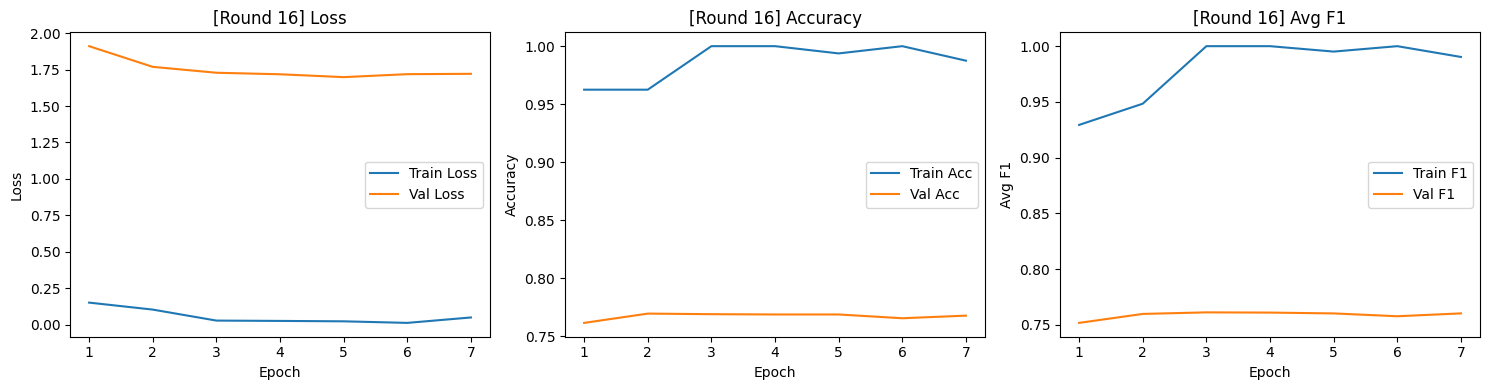


[AL Round 17/60] — Labeled samples: 170

Epoch 1/7


Train — Loss: 0.0727 | Acc: 0.9765 | Avg F1: 0.9576
Val   — Loss: 1.6547 | Acc: 0.7680 | Avg F1: 0.7594

Epoch 2/7


Train — Loss: 0.0532 | Acc: 0.9882 | Avg F1: 0.9909
Val   — Loss: 1.6035 | Acc: 0.7672 | Avg F1: 0.7579

Epoch 3/7


Train — Loss: 0.0302 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.5976 | Acc: 0.7645 | Avg F1: 0.7558

Epoch 4/7


Train — Loss: 0.0945 | Acc: 0.9706 | Avg F1: 0.9773
Val   — Loss: 1.6118 | Acc: 0.7705 | Avg F1: 0.7616

Epoch 5/7


Train — Loss: 0.0304 | Acc: 0.9941 | Avg F1: 0.9954
Val   — Loss: 1.6464 | Acc: 0.7710 | Avg F1: 0.7609

Epoch 6/7


Train — Loss: 0.0238 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.6832 | Acc: 0.7725 | Avg F1: 0.7636

Epoch 7/7


Train — Loss: 0.0156 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.7259 | Acc: 0.7738 | Avg F1: 0.7661


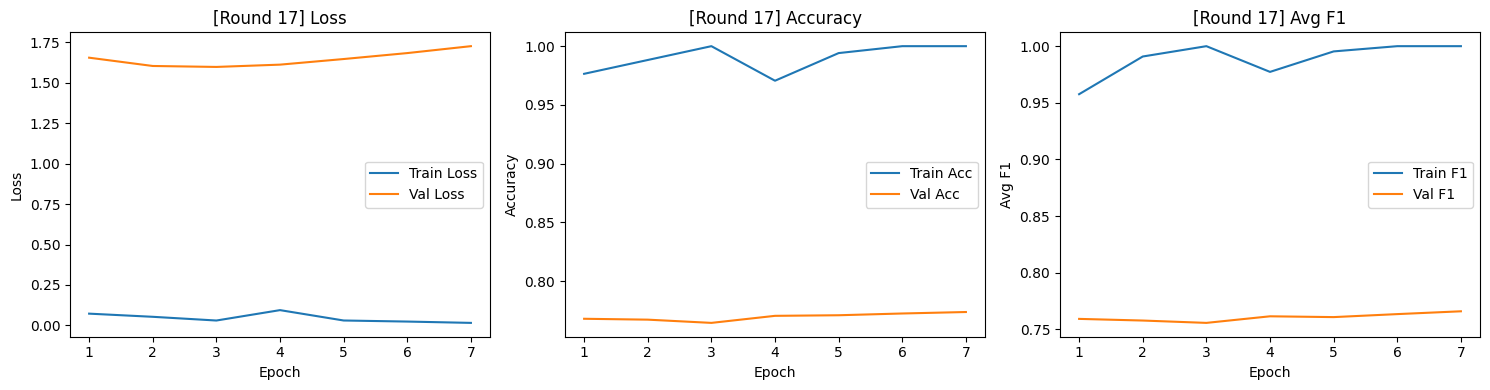


[AL Round 18/60] — Labeled samples: 180

Epoch 1/7


Train — Loss: 0.1160 | Acc: 0.9500 | Avg F1: 0.8862
Val   — Loss: 1.6835 | Acc: 0.7770 | Avg F1: 0.7699

Epoch 2/7


Train — Loss: 0.0847 | Acc: 0.9722 | Avg F1: 0.9189
Val   — Loss: 1.6170 | Acc: 0.7805 | Avg F1: 0.7720

Epoch 3/7


Train — Loss: 0.0453 | Acc: 0.9889 | Avg F1: 0.9467
Val   — Loss: 1.5891 | Acc: 0.7755 | Avg F1: 0.7685

Epoch 4/7


Train — Loss: 0.0388 | Acc: 0.9889 | Avg F1: 0.9915
Val   — Loss: 1.5951 | Acc: 0.7738 | Avg F1: 0.7665

Epoch 5/7


Train — Loss: 0.0238 | Acc: 0.9944 | Avg F1: 0.9957
Val   — Loss: 1.6163 | Acc: 0.7775 | Avg F1: 0.7693

Epoch 6/7


Train — Loss: 0.0307 | Acc: 0.9944 | Avg F1: 0.9957
Val   — Loss: 1.6555 | Acc: 0.7762 | Avg F1: 0.7676

Epoch 7/7


Train — Loss: 0.0062 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.6893 | Acc: 0.7775 | Avg F1: 0.7692


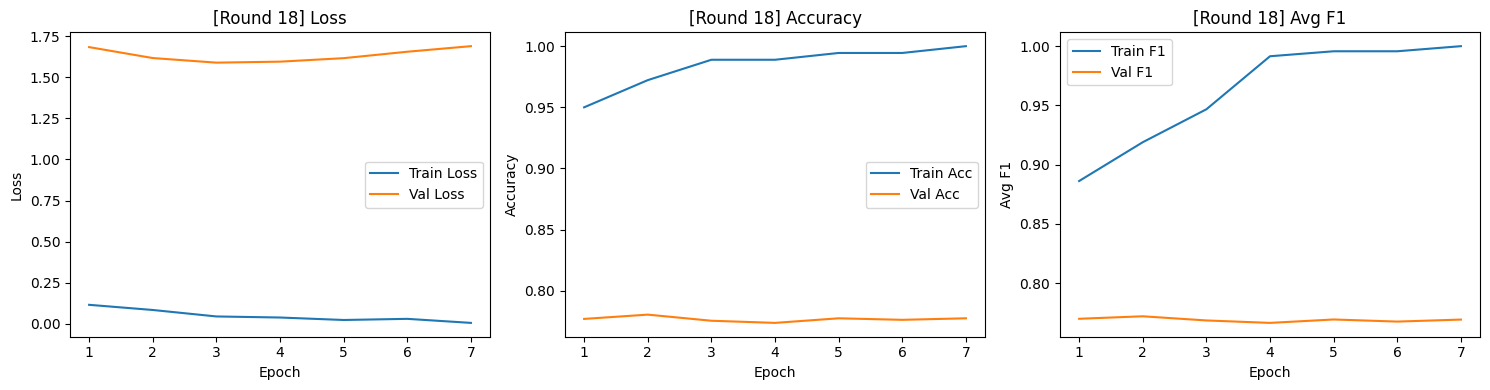


[AL Round 19/60] — Labeled samples: 190

Epoch 1/7


Train — Loss: 0.0681 | Acc: 0.9632 | Avg F1: 0.9193
Val   — Loss: 1.7021 | Acc: 0.7845 | Avg F1: 0.7774

Epoch 2/7


Train — Loss: 0.0461 | Acc: 0.9842 | Avg F1: 0.9668
Val   — Loss: 1.7213 | Acc: 0.7880 | Avg F1: 0.7817

Epoch 3/7


Train — Loss: 0.0197 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.7293 | Acc: 0.7867 | Avg F1: 0.7813

Epoch 4/7


Train — Loss: 0.0303 | Acc: 0.9895 | Avg F1: 0.9723
Val   — Loss: 1.7061 | Acc: 0.7880 | Avg F1: 0.7831

Epoch 5/7


Train — Loss: 0.0179 | Acc: 0.9947 | Avg F1: 0.9959
Val   — Loss: 1.6860 | Acc: 0.7887 | Avg F1: 0.7830

Epoch 6/7


Train — Loss: 0.0394 | Acc: 0.9895 | Avg F1: 0.9723
Val   — Loss: 1.6865 | Acc: 0.7890 | Avg F1: 0.7825

Epoch 7/7


Train — Loss: 0.0113 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.6941 | Acc: 0.7877 | Avg F1: 0.7808


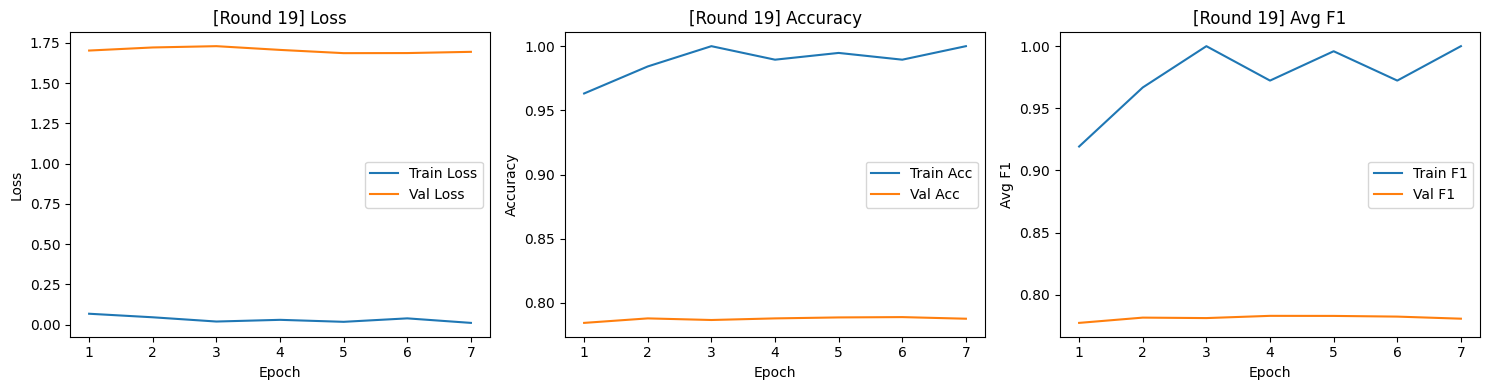


[AL Round 20/60] — Labeled samples: 200

Epoch 1/7


Train — Loss: 0.1558 | Acc: 0.9500 | Avg F1: 0.9616
Val   — Loss: 1.6755 | Acc: 0.7890 | Avg F1: 0.7822

Epoch 2/7


Train — Loss: 0.0314 | Acc: 0.9950 | Avg F1: 0.9962
Val   — Loss: 1.7977 | Acc: 0.7662 | Avg F1: 0.7593

Epoch 3/7


Train — Loss: 0.1410 | Acc: 0.9650 | Avg F1: 0.9538
Val   — Loss: 1.7841 | Acc: 0.7728 | Avg F1: 0.7681

Epoch 4/7


Train — Loss: 0.0707 | Acc: 0.9800 | Avg F1: 0.9846
Val   — Loss: 2.1219 | Acc: 0.7690 | Avg F1: 0.7688

Epoch 5/7


Train — Loss: 0.1037 | Acc: 0.9600 | Avg F1: 0.9184
Val   — Loss: 2.5779 | Acc: 0.7282 | Avg F1: 0.7285

Epoch 6/7


Train — Loss: 0.1554 | Acc: 0.9250 | Avg F1: 0.8722
Val   — Loss: 1.9316 | Acc: 0.7665 | Avg F1: 0.7700

Epoch 7/7


Train — Loss: 0.1393 | Acc: 0.9450 | Avg F1: 0.9335
Val   — Loss: 1.4626 | Acc: 0.7810 | Avg F1: 0.7755


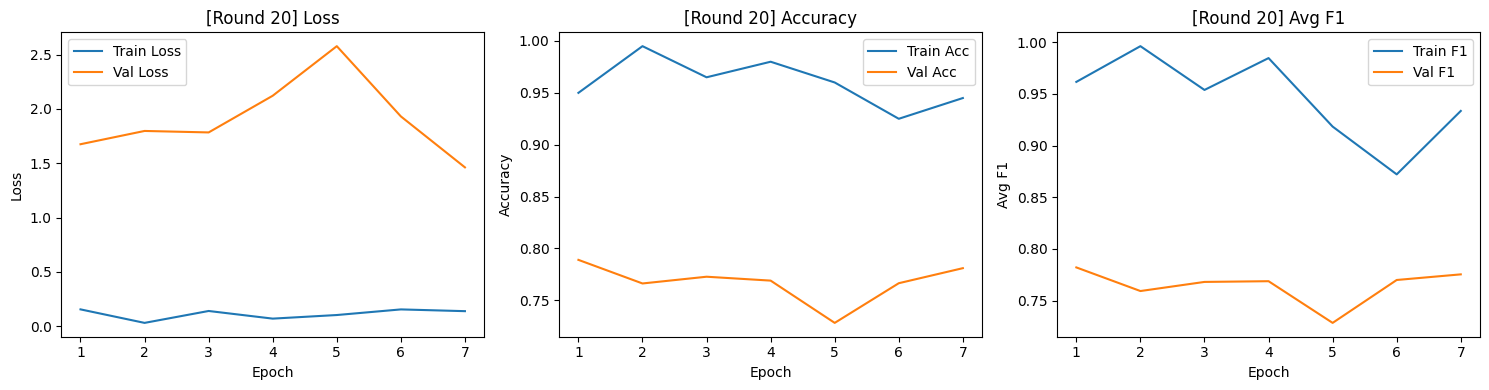


[AL Round 21/60] — Labeled samples: 210

Epoch 1/7


Train — Loss: 0.1224 | Acc: 0.9571 | Avg F1: 0.9140
Val   — Loss: 2.7176 | Acc: 0.6593 | Avg F1: 0.6405

Epoch 2/7


Train — Loss: 0.2640 | Acc: 0.9238 | Avg F1: 0.9047
Val   — Loss: 2.4483 | Acc: 0.6767 | Avg F1: 0.6628

Epoch 3/7


Train — Loss: 0.2565 | Acc: 0.9286 | Avg F1: 0.9465
Val   — Loss: 1.3298 | Acc: 0.7702 | Avg F1: 0.7644

Epoch 4/7


Train — Loss: 0.0624 | Acc: 0.9857 | Avg F1: 0.9892
Val   — Loss: 1.4960 | Acc: 0.7732 | Avg F1: 0.7746

Epoch 5/7


Train — Loss: 0.0579 | Acc: 0.9952 | Avg F1: 0.9964
Val   — Loss: 1.7675 | Acc: 0.7465 | Avg F1: 0.7522

Epoch 6/7


Train — Loss: 0.0849 | Acc: 0.9667 | Avg F1: 0.9744
Val   — Loss: 1.4280 | Acc: 0.7732 | Avg F1: 0.7742

Epoch 7/7


Train — Loss: 0.0289 | Acc: 0.9952 | Avg F1: 0.9964
Val   — Loss: 1.2172 | Acc: 0.7885 | Avg F1: 0.7834


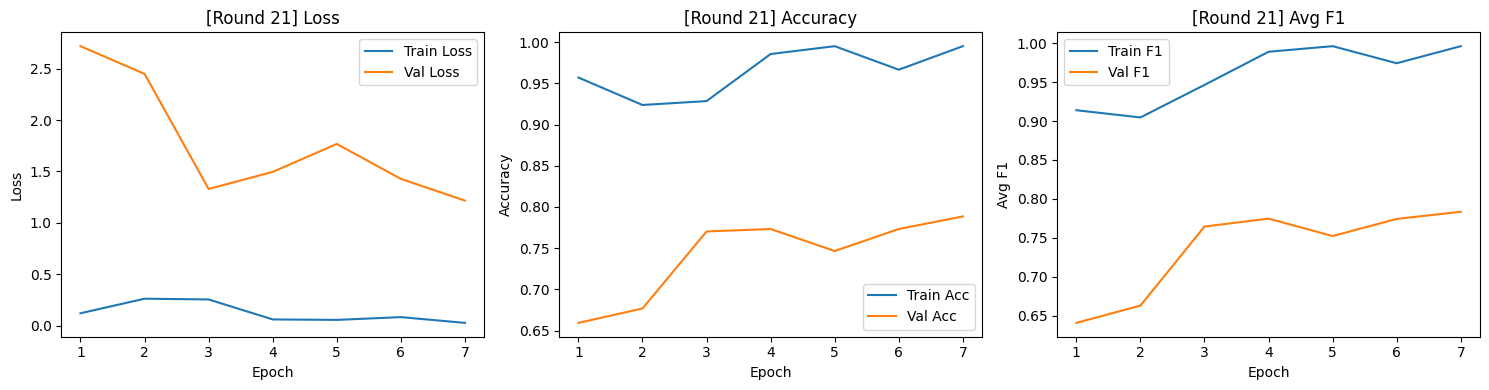


[AL Round 22/60] — Labeled samples: 220

Epoch 1/7


Train — Loss: 0.0615 | Acc: 0.9727 | Avg F1: 0.9305
Val   — Loss: 1.1371 | Acc: 0.7963 | Avg F1: 0.7867

Epoch 2/7


Train — Loss: 0.0467 | Acc: 0.9864 | Avg F1: 0.9898
Val   — Loss: 1.1364 | Acc: 0.7917 | Avg F1: 0.7814

Epoch 3/7


Train — Loss: 0.0266 | Acc: 0.9864 | Avg F1: 0.9898
Val   — Loss: 1.1561 | Acc: 0.7860 | Avg F1: 0.7745

Epoch 4/7


Train — Loss: 0.0366 | Acc: 0.9909 | Avg F1: 0.9932
Val   — Loss: 1.1729 | Acc: 0.7883 | Avg F1: 0.7771

Epoch 5/7


Train — Loss: 0.0204 | Acc: 0.9955 | Avg F1: 0.9966
Val   — Loss: 1.1859 | Acc: 0.7895 | Avg F1: 0.7803

Epoch 6/7


Train — Loss: 0.0077 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1959 | Acc: 0.7900 | Avg F1: 0.7807

Epoch 7/7


Train — Loss: 0.0090 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.2131 | Acc: 0.7920 | Avg F1: 0.7831


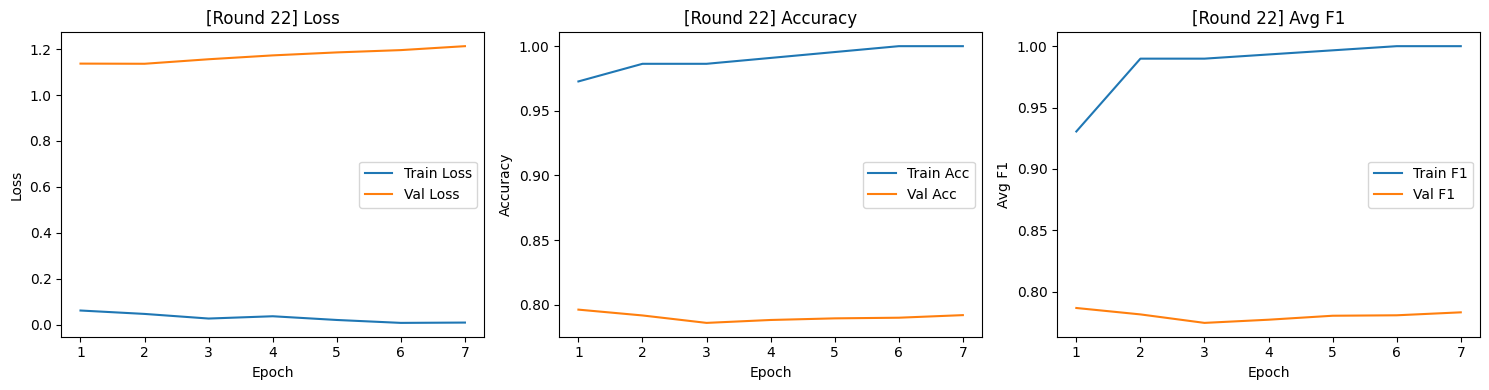


[AL Round 23/60] — Labeled samples: 230

Epoch 1/7


Train — Loss: 0.0967 | Acc: 0.9696 | Avg F1: 0.9599
Val   — Loss: 1.1934 | Acc: 0.7955 | Avg F1: 0.7855

Epoch 2/7


Train — Loss: 0.0557 | Acc: 0.9826 | Avg F1: 0.9695
Val   — Loss: 1.1761 | Acc: 0.7995 | Avg F1: 0.7900

Epoch 3/7


Train — Loss: 0.0256 | Acc: 0.9913 | Avg F1: 0.9751
Val   — Loss: 1.1591 | Acc: 0.7997 | Avg F1: 0.7893

Epoch 4/7


Train — Loss: 0.0141 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1430 | Acc: 0.7995 | Avg F1: 0.7890

Epoch 5/7


Train — Loss: 0.0109 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1442 | Acc: 0.8000 | Avg F1: 0.7898

Epoch 6/7


Train — Loss: 0.0059 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1355 | Acc: 0.8000 | Avg F1: 0.7905

Epoch 7/7


Train — Loss: 0.0093 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1403 | Acc: 0.8007 | Avg F1: 0.7919


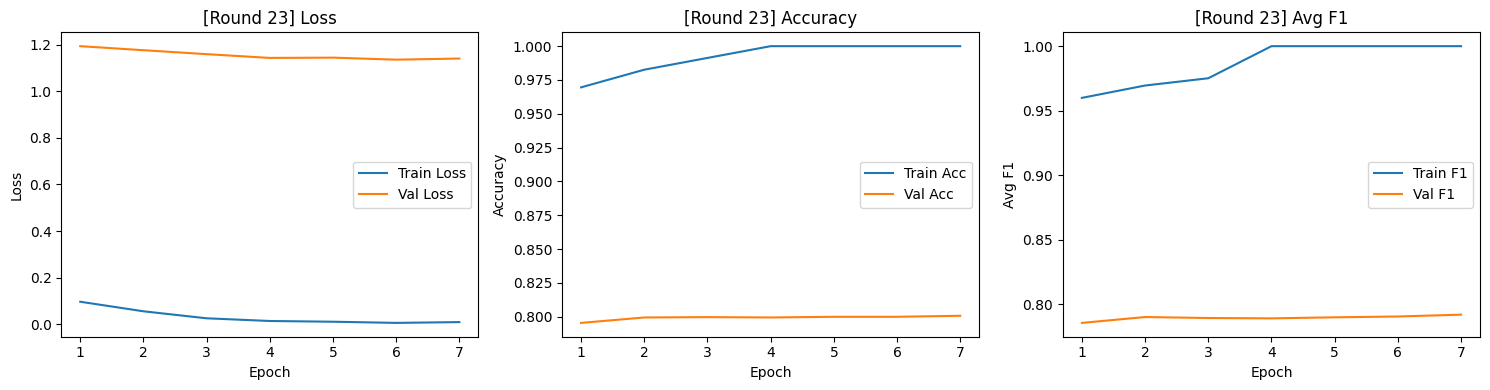


[AL Round 24/60] — Labeled samples: 240

Epoch 1/7


Train — Loss: 0.1065 | Acc: 0.9708 | Avg F1: 0.9511
Val   — Loss: 1.1397 | Acc: 0.8045 | Avg F1: 0.7985

Epoch 2/7


Train — Loss: 0.0420 | Acc: 0.9792 | Avg F1: 0.9427
Val   — Loss: 1.1336 | Acc: 0.8040 | Avg F1: 0.8008

Epoch 3/7


Train — Loss: 0.0303 | Acc: 0.9875 | Avg F1: 0.9768
Val   — Loss: 1.0787 | Acc: 0.8100 | Avg F1: 0.8076

Epoch 4/7


Train — Loss: 0.0170 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0461 | Acc: 0.8137 | Avg F1: 0.8094

Epoch 5/7


Train — Loss: 0.0119 | Acc: 0.9958 | Avg F1: 0.9822
Val   — Loss: 1.0356 | Acc: 0.8185 | Avg F1: 0.8129

Epoch 6/7


Train — Loss: 0.0193 | Acc: 0.9958 | Avg F1: 0.9969
Val   — Loss: 1.0289 | Acc: 0.8180 | Avg F1: 0.8109

Epoch 7/7


Train — Loss: 0.0063 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0311 | Acc: 0.8173 | Avg F1: 0.8106


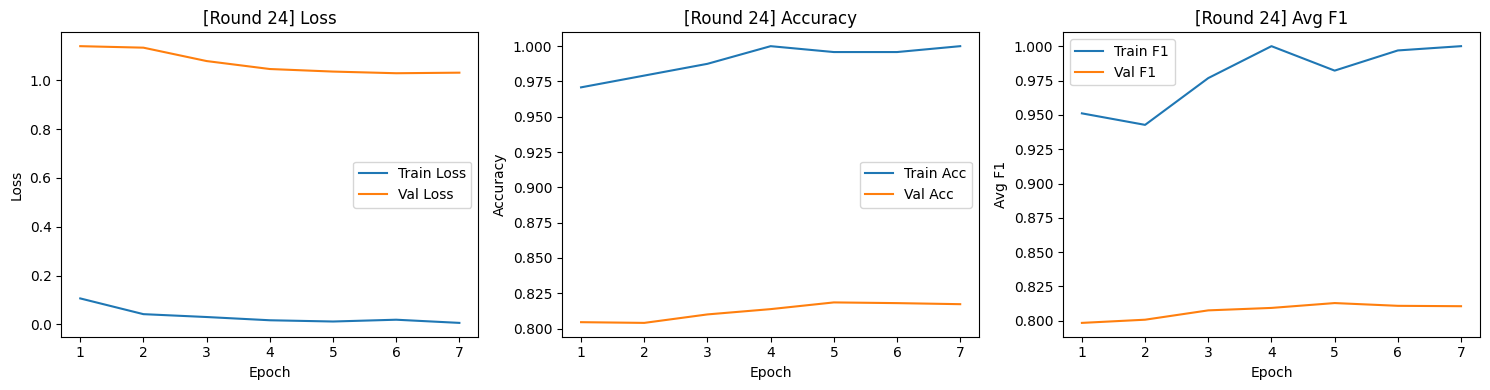


[AL Round 25/60] — Labeled samples: 250

Epoch 1/7


Train — Loss: 0.0781 | Acc: 0.9720 | Avg F1: 0.9287
Val   — Loss: 1.0231 | Acc: 0.8187 | Avg F1: 0.8116

Epoch 2/7


Train — Loss: 0.1170 | Acc: 0.9720 | Avg F1: 0.9494
Val   — Loss: 1.0323 | Acc: 0.8230 | Avg F1: 0.8187

Epoch 3/7


Train — Loss: 0.0314 | Acc: 0.9920 | Avg F1: 0.9940
Val   — Loss: 1.0921 | Acc: 0.8193 | Avg F1: 0.8161

Epoch 4/7


Train — Loss: 0.0259 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1372 | Acc: 0.8177 | Avg F1: 0.8156

Epoch 5/7


Train — Loss: 0.0171 | Acc: 0.9960 | Avg F1: 0.9970
Val   — Loss: 1.1310 | Acc: 0.8175 | Avg F1: 0.8158

Epoch 6/7


Train — Loss: 0.0071 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1160 | Acc: 0.8190 | Avg F1: 0.8172

Epoch 7/7


Train — Loss: 0.0086 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1025 | Acc: 0.8193 | Avg F1: 0.8171


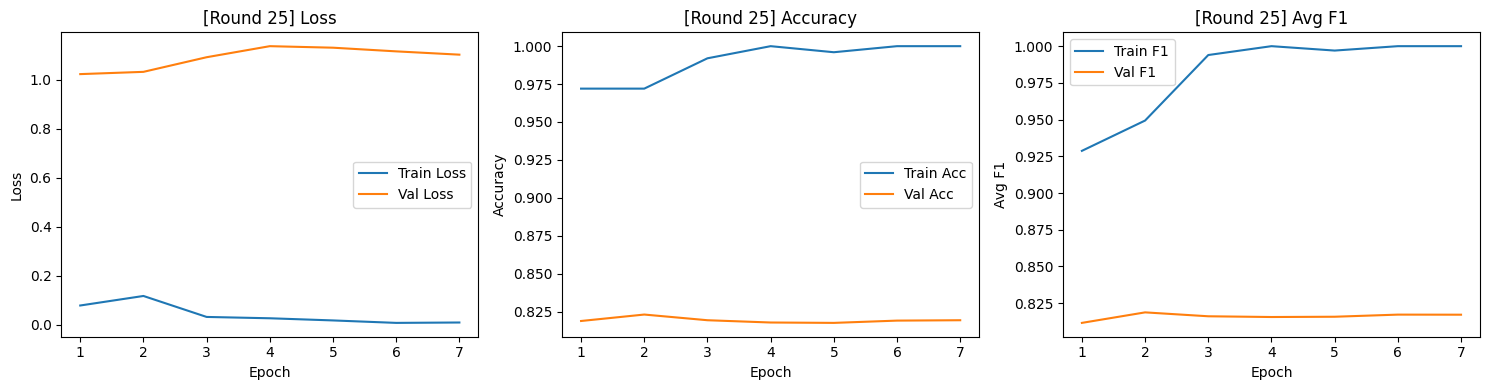


[AL Round 26/60] — Labeled samples: 260

Epoch 1/7


Train — Loss: 0.0568 | Acc: 0.9731 | Avg F1: 0.9703
Val   — Loss: 1.0935 | Acc: 0.8210 | Avg F1: 0.8202

Epoch 2/7


Train — Loss: 0.0380 | Acc: 0.9846 | Avg F1: 0.9711
Val   — Loss: 1.2771 | Acc: 0.7845 | Avg F1: 0.7873

Epoch 3/7


Train — Loss: 0.0974 | Acc: 0.9769 | Avg F1: 0.9431
Val   — Loss: 1.0968 | Acc: 0.8027 | Avg F1: 0.7953

Epoch 4/7


Train — Loss: 0.1013 | Acc: 0.9692 | Avg F1: 0.9182
Val   — Loss: 1.1545 | Acc: 0.7705 | Avg F1: 0.7614

Epoch 5/7


Train — Loss: 0.1569 | Acc: 0.9538 | Avg F1: 0.9261
Val   — Loss: 1.0216 | Acc: 0.7857 | Avg F1: 0.7754

Epoch 6/7


Train — Loss: 0.0576 | Acc: 0.9923 | Avg F1: 0.9943
Val   — Loss: 1.1074 | Acc: 0.8023 | Avg F1: 0.7929

Epoch 7/7


Train — Loss: 0.1431 | Acc: 0.9692 | Avg F1: 0.9768
Val   — Loss: 1.5193 | Acc: 0.7580 | Avg F1: 0.7319


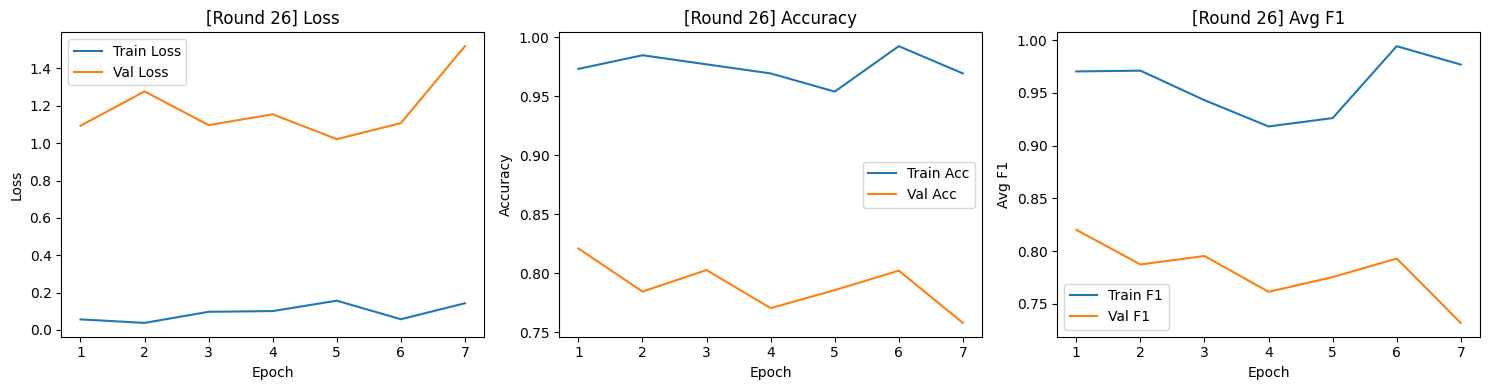


[AL Round 27/60] — Labeled samples: 270

Epoch 1/7


Train — Loss: 0.2989 | Acc: 0.9222 | Avg F1: 0.8880
Val   — Loss: 1.3578 | Acc: 0.7610 | Avg F1: 0.7427

Epoch 2/7


Train — Loss: 0.1421 | Acc: 0.9630 | Avg F1: 0.9340
Val   — Loss: 1.4581 | Acc: 0.7490 | Avg F1: 0.7440

Epoch 3/7


Train — Loss: 0.1735 | Acc: 0.9444 | Avg F1: 0.9266
Val   — Loss: 1.1710 | Acc: 0.7735 | Avg F1: 0.7677

Epoch 4/7


Train — Loss: 0.0693 | Acc: 0.9852 | Avg F1: 0.9733
Val   — Loss: 1.0446 | Acc: 0.7860 | Avg F1: 0.7812

Epoch 5/7


Train — Loss: 0.0805 | Acc: 0.9667 | Avg F1: 0.9601
Val   — Loss: 1.0911 | Acc: 0.7925 | Avg F1: 0.7904

Epoch 6/7


Train — Loss: 0.0359 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.1507 | Acc: 0.7913 | Avg F1: 0.7907

Epoch 7/7


Train — Loss: 0.0351 | Acc: 0.9963 | Avg F1: 0.9973
Val   — Loss: 1.1556 | Acc: 0.7937 | Avg F1: 0.7940


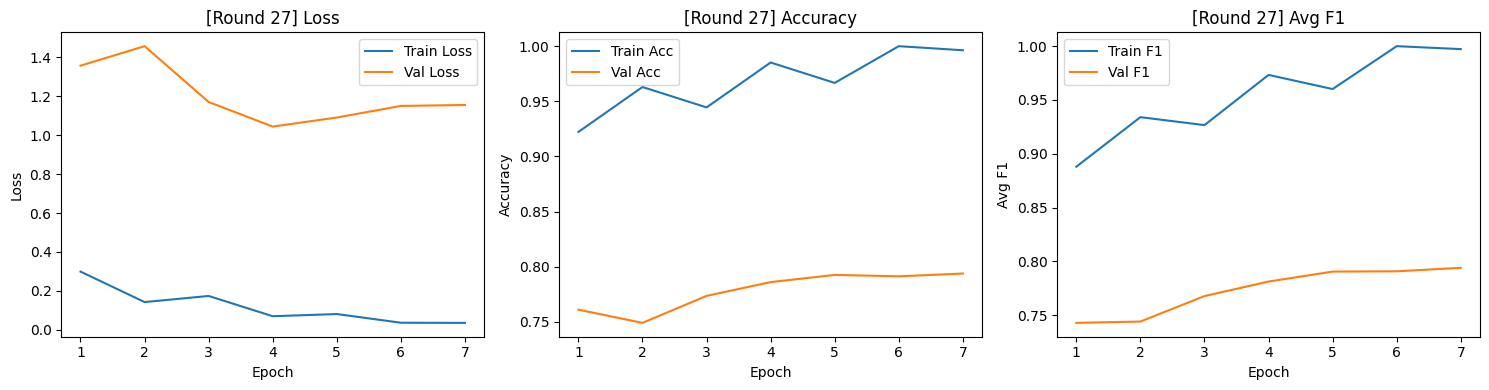


[AL Round 28/60] — Labeled samples: 280

Epoch 1/7


Train — Loss: 0.0452 | Acc: 0.9893 | Avg F1: 0.9767
Val   — Loss: 1.1324 | Acc: 0.8005 | Avg F1: 0.8014

Epoch 2/7


Train — Loss: 0.0390 | Acc: 0.9893 | Avg F1: 0.9841
Val   — Loss: 1.0304 | Acc: 0.8135 | Avg F1: 0.8119

Epoch 3/7


Train — Loss: 0.0366 | Acc: 0.9893 | Avg F1: 0.9920
Val   — Loss: 0.9784 | Acc: 0.8190 | Avg F1: 0.8178

Epoch 4/7


Train — Loss: 0.0267 | Acc: 0.9964 | Avg F1: 0.9973
Val   — Loss: 0.9732 | Acc: 0.8190 | Avg F1: 0.8188

Epoch 5/7


Train — Loss: 0.0176 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9812 | Acc: 0.8203 | Avg F1: 0.8203

Epoch 6/7


Train — Loss: 0.0132 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0041 | Acc: 0.8210 | Avg F1: 0.8214

Epoch 7/7


Train — Loss: 0.0183 | Acc: 0.9964 | Avg F1: 0.9973
Val   — Loss: 1.0162 | Acc: 0.8215 | Avg F1: 0.8217


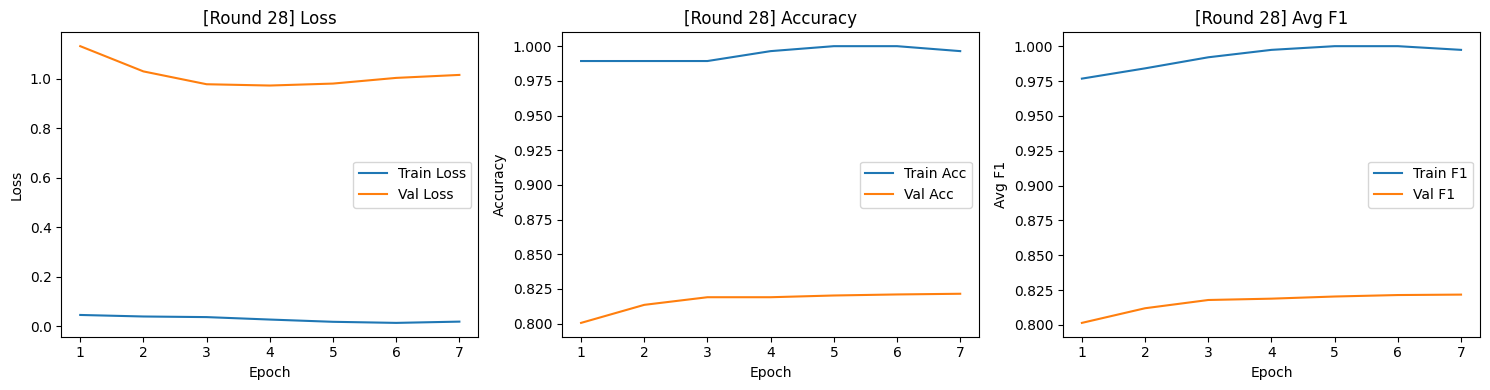


[AL Round 29/60] — Labeled samples: 290

Epoch 1/7


Train — Loss: 0.0704 | Acc: 0.9793 | Avg F1: 0.9779
Val   — Loss: 0.9683 | Acc: 0.8260 | Avg F1: 0.8280

Epoch 2/7


Train — Loss: 0.0371 | Acc: 0.9862 | Avg F1: 0.9827
Val   — Loss: 0.9389 | Acc: 0.8257 | Avg F1: 0.8271

Epoch 3/7


Train — Loss: 0.0225 | Acc: 0.9931 | Avg F1: 0.9948
Val   — Loss: 0.9259 | Acc: 0.8245 | Avg F1: 0.8256

Epoch 4/7


Train — Loss: 0.0144 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9063 | Acc: 0.8270 | Avg F1: 0.8273

Epoch 5/7


Train — Loss: 0.0103 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8975 | Acc: 0.8253 | Avg F1: 0.8249

Epoch 6/7


Train — Loss: 0.0065 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9014 | Acc: 0.8285 | Avg F1: 0.8283

Epoch 7/7


Train — Loss: 0.0063 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9083 | Acc: 0.8275 | Avg F1: 0.8280


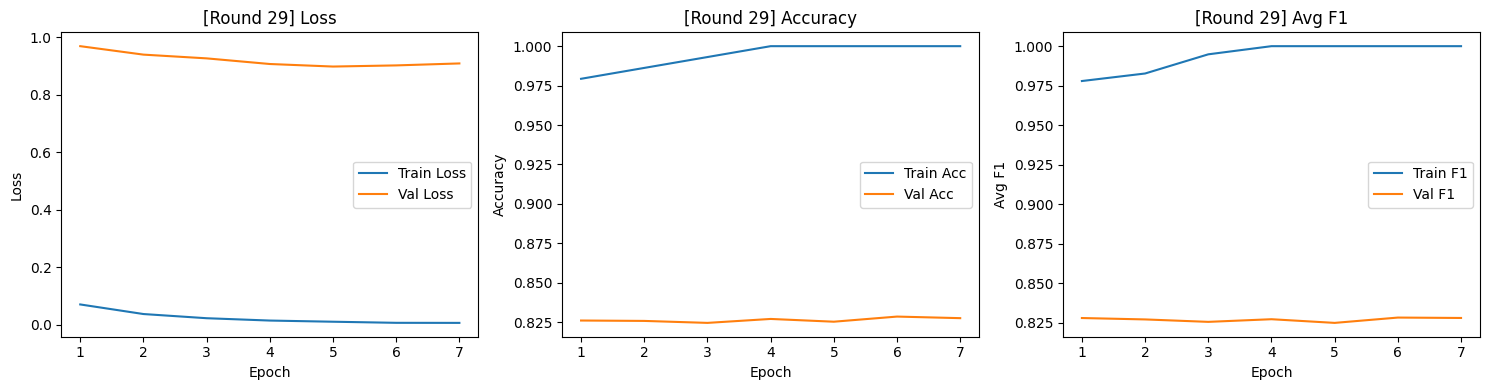


[AL Round 30/60] — Labeled samples: 300

Epoch 1/7


Train — Loss: 0.0717 | Acc: 0.9700 | Avg F1: 0.9464
Val   — Loss: 0.8988 | Acc: 0.8287 | Avg F1: 0.8281

Epoch 2/7


Train — Loss: 0.0293 | Acc: 0.9867 | Avg F1: 0.9761
Val   — Loss: 0.8917 | Acc: 0.8285 | Avg F1: 0.8280

Epoch 3/7


Train — Loss: 0.0196 | Acc: 0.9967 | Avg F1: 0.9909
Val   — Loss: 0.8940 | Acc: 0.8300 | Avg F1: 0.8295

Epoch 4/7


Train — Loss: 0.0090 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8953 | Acc: 0.8287 | Avg F1: 0.8288

Epoch 5/7


Train — Loss: 0.0070 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8990 | Acc: 0.8295 | Avg F1: 0.8299

Epoch 6/7


Train — Loss: 0.0101 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9033 | Acc: 0.8287 | Avg F1: 0.8292

Epoch 7/7


Train — Loss: 0.0097 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9009 | Acc: 0.8297 | Avg F1: 0.8306


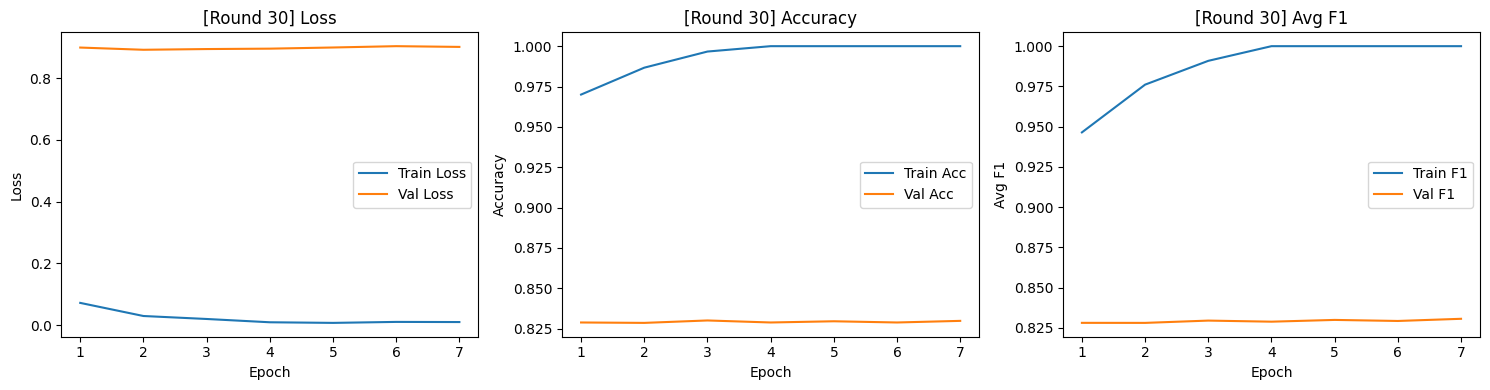


[AL Round 31/60] — Labeled samples: 310

Epoch 1/7


Train — Loss: 0.0836 | Acc: 0.9774 | Avg F1: 0.9606
Val   — Loss: 0.9029 | Acc: 0.8343 | Avg F1: 0.8367

Epoch 2/7


Train — Loss: 0.0304 | Acc: 0.9935 | Avg F1: 0.9951
Val   — Loss: 0.9053 | Acc: 0.8323 | Avg F1: 0.8345

Epoch 3/7


Train — Loss: 0.0234 | Acc: 0.9935 | Avg F1: 0.9890
Val   — Loss: 0.9223 | Acc: 0.8335 | Avg F1: 0.8360

Epoch 4/7


Train — Loss: 0.0136 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9310 | Acc: 0.8323 | Avg F1: 0.8341

Epoch 5/7


Train — Loss: 0.0128 | Acc: 0.9968 | Avg F1: 0.9922
Val   — Loss: 0.9260 | Acc: 0.8327 | Avg F1: 0.8351

Epoch 6/7


Train — Loss: 0.0073 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9195 | Acc: 0.8320 | Avg F1: 0.8348

Epoch 7/7


Train — Loss: 0.0083 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9167 | Acc: 0.8323 | Avg F1: 0.8347


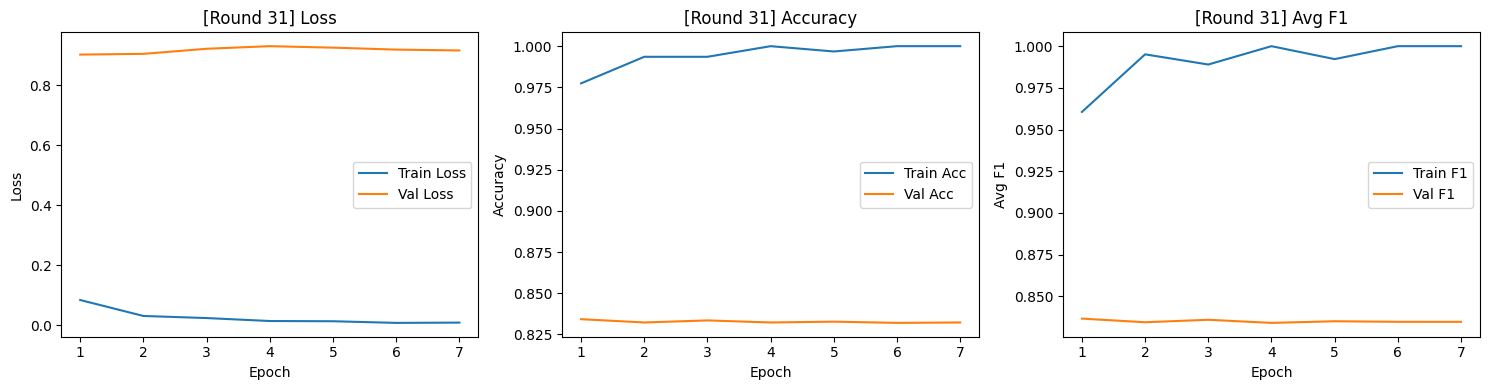


[AL Round 32/60] — Labeled samples: 320

Epoch 1/7


Train — Loss: 0.0714 | Acc: 0.9688 | Avg F1: 0.9655
Val   — Loss: 0.9083 | Acc: 0.8303 | Avg F1: 0.8325

Epoch 2/7


Train — Loss: 0.0278 | Acc: 0.9906 | Avg F1: 0.9819
Val   — Loss: 0.9192 | Acc: 0.8305 | Avg F1: 0.8331

Epoch 3/7


Train — Loss: 0.0125 | Acc: 0.9969 | Avg F1: 0.9918
Val   — Loss: 0.9245 | Acc: 0.8267 | Avg F1: 0.8298

Epoch 4/7


Train — Loss: 0.0148 | Acc: 0.9969 | Avg F1: 0.9976
Val   — Loss: 0.9165 | Acc: 0.8275 | Avg F1: 0.8302

Epoch 5/7


Train — Loss: 0.0150 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9044 | Acc: 0.8303 | Avg F1: 0.8329

Epoch 6/7


Train — Loss: 0.0088 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8956 | Acc: 0.8310 | Avg F1: 0.8329

Epoch 7/7


Train — Loss: 0.0087 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8944 | Acc: 0.8320 | Avg F1: 0.8335


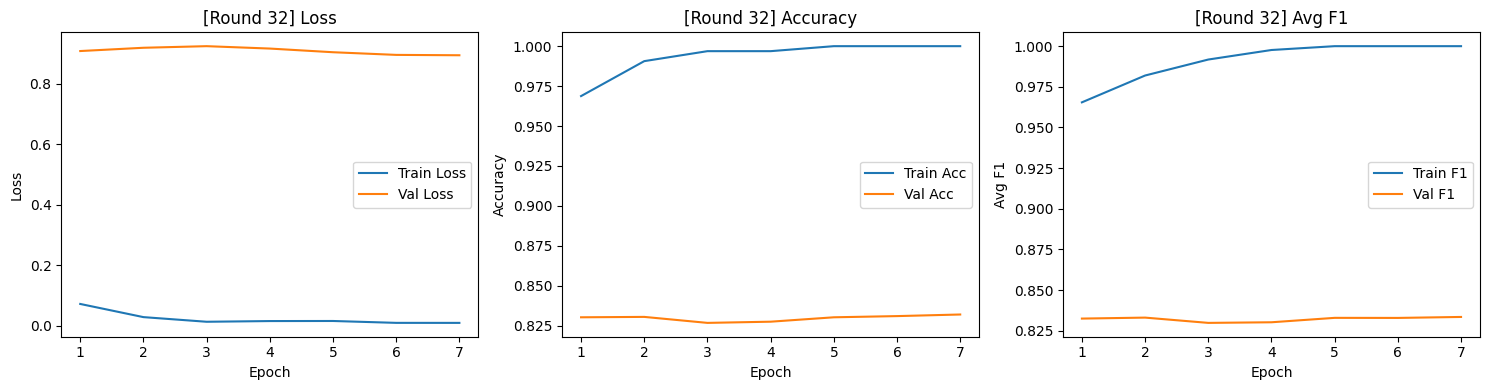


[AL Round 33/60] — Labeled samples: 330

Epoch 1/7


Train — Loss: 0.0566 | Acc: 0.9758 | Avg F1: 0.9615
Val   — Loss: 0.9147 | Acc: 0.8275 | Avg F1: 0.8317

Epoch 2/7


Train — Loss: 0.0481 | Acc: 0.9879 | Avg F1: 0.9857
Val   — Loss: 0.9732 | Acc: 0.8085 | Avg F1: 0.8170

Epoch 3/7


Train — Loss: 0.0414 | Acc: 0.9879 | Avg F1: 0.9909
Val   — Loss: 0.9393 | Acc: 0.8257 | Avg F1: 0.8305

Epoch 4/7


Train — Loss: 0.0454 | Acc: 0.9818 | Avg F1: 0.9809
Val   — Loss: 0.9197 | Acc: 0.8253 | Avg F1: 0.8304

Epoch 5/7


Train — Loss: 0.0388 | Acc: 0.9939 | Avg F1: 0.9954
Val   — Loss: 1.5347 | Acc: 0.7530 | Avg F1: 0.7621

Epoch 6/7


Train — Loss: 0.0417 | Acc: 0.9879 | Avg F1: 0.9909
Val   — Loss: 1.1960 | Acc: 0.8060 | Avg F1: 0.8129

Epoch 7/7


Train — Loss: 0.0730 | Acc: 0.9848 | Avg F1: 0.9887
Val   — Loss: 1.0565 | Acc: 0.8180 | Avg F1: 0.8210


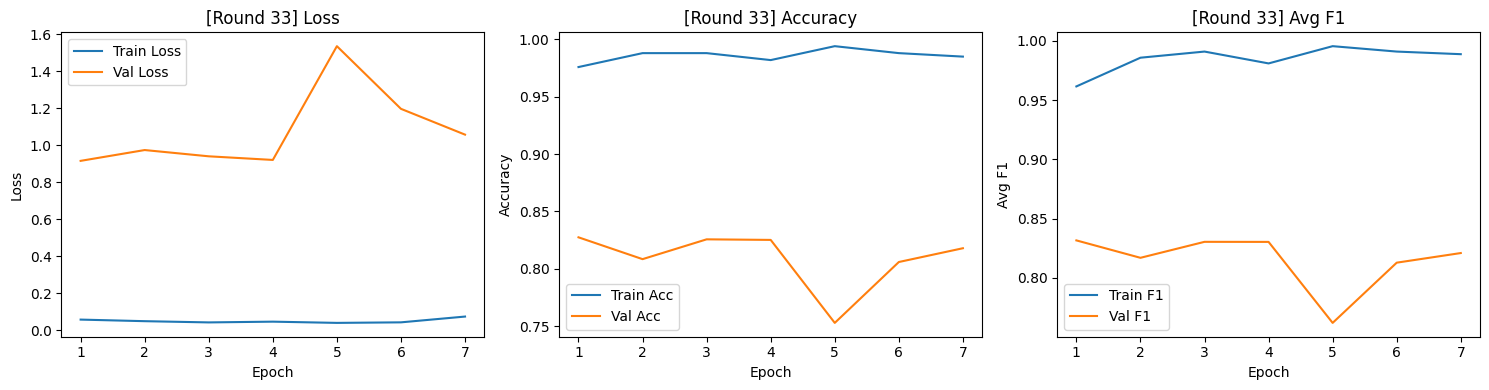


[AL Round 34/60] — Labeled samples: 340

Epoch 1/7


Train — Loss: 0.0725 | Acc: 0.9735 | Avg F1: 0.9595
Val   — Loss: 1.0183 | Acc: 0.8240 | Avg F1: 0.8279

Epoch 2/7


Train — Loss: 0.0570 | Acc: 0.9794 | Avg F1: 0.9684
Val   — Loss: 0.9923 | Acc: 0.8325 | Avg F1: 0.8332

Epoch 3/7


Train — Loss: 0.0296 | Acc: 0.9882 | Avg F1: 0.9810
Val   — Loss: 1.0060 | Acc: 0.8267 | Avg F1: 0.8303

Epoch 4/7


Train — Loss: 0.0237 | Acc: 0.9971 | Avg F1: 0.9928
Val   — Loss: 0.9502 | Acc: 0.8327 | Avg F1: 0.8347

Epoch 5/7


Train — Loss: 0.0176 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8932 | Acc: 0.8360 | Avg F1: 0.8365

Epoch 6/7


Train — Loss: 0.0117 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8689 | Acc: 0.8375 | Avg F1: 0.8379

Epoch 7/7


Train — Loss: 0.0203 | Acc: 0.9971 | Avg F1: 0.9978
Val   — Loss: 0.8644 | Acc: 0.8407 | Avg F1: 0.8407


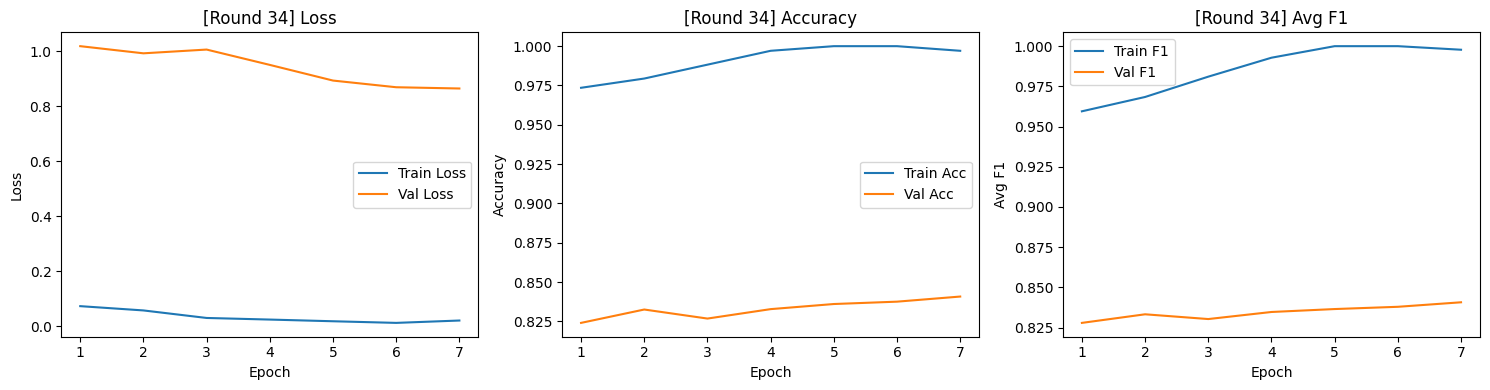


[AL Round 35/60] — Labeled samples: 350

Epoch 1/7


Train — Loss: 0.0489 | Acc: 0.9829 | Avg F1: 0.9774
Val   — Loss: 0.8837 | Acc: 0.8415 | Avg F1: 0.8436

Epoch 2/7


Train — Loss: 0.0238 | Acc: 0.9943 | Avg F1: 0.9957
Val   — Loss: 0.8873 | Acc: 0.8415 | Avg F1: 0.8436

Epoch 3/7


Train — Loss: 0.0110 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9033 | Acc: 0.8410 | Avg F1: 0.8440

Epoch 4/7


Train — Loss: 0.0183 | Acc: 0.9971 | Avg F1: 0.9978
Val   — Loss: 0.9030 | Acc: 0.8400 | Avg F1: 0.8436

Epoch 5/7


Train — Loss: 0.0080 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9043 | Acc: 0.8373 | Avg F1: 0.8403

Epoch 6/7


Train — Loss: 0.0056 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9069 | Acc: 0.8380 | Avg F1: 0.8403

Epoch 7/7


Train — Loss: 0.0055 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9149 | Acc: 0.8365 | Avg F1: 0.8391


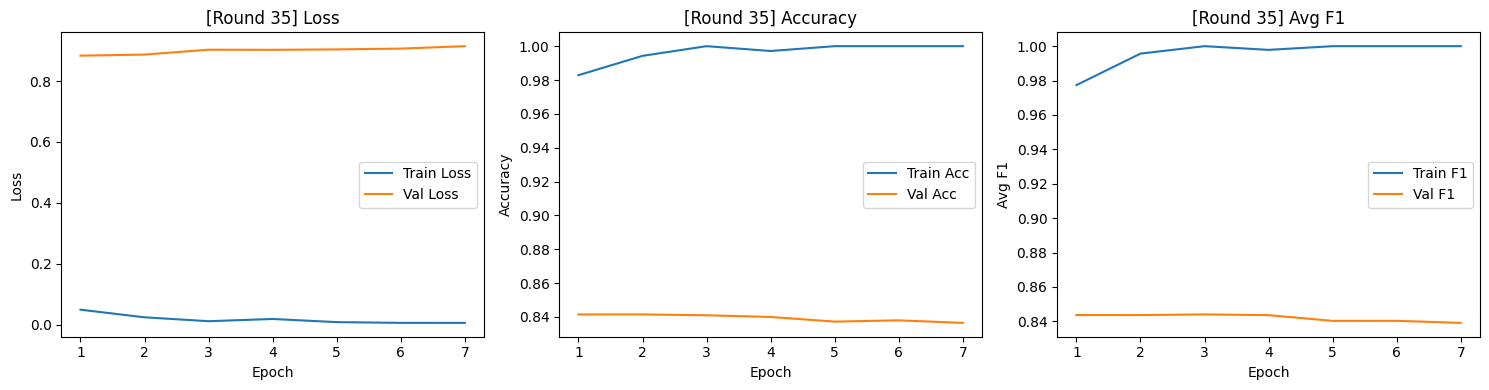


[AL Round 36/60] — Labeled samples: 360

Epoch 1/7


Train — Loss: 0.0482 | Acc: 0.9778 | Avg F1: 0.9652
Val   — Loss: 0.9046 | Acc: 0.8385 | Avg F1: 0.8421

Epoch 2/7


Train — Loss: 0.0190 | Acc: 0.9972 | Avg F1: 0.9979
Val   — Loss: 0.9233 | Acc: 0.8410 | Avg F1: 0.8457

Epoch 3/7


Train — Loss: 0.0110 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9403 | Acc: 0.8417 | Avg F1: 0.8464

Epoch 4/7


Train — Loss: 0.0093 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9250 | Acc: 0.8405 | Avg F1: 0.8452

Epoch 5/7


Train — Loss: 0.0113 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9111 | Acc: 0.8385 | Avg F1: 0.8430

Epoch 6/7


Train — Loss: 0.0106 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9041 | Acc: 0.8375 | Avg F1: 0.8421

Epoch 7/7


Train — Loss: 0.0045 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8999 | Acc: 0.8395 | Avg F1: 0.8444


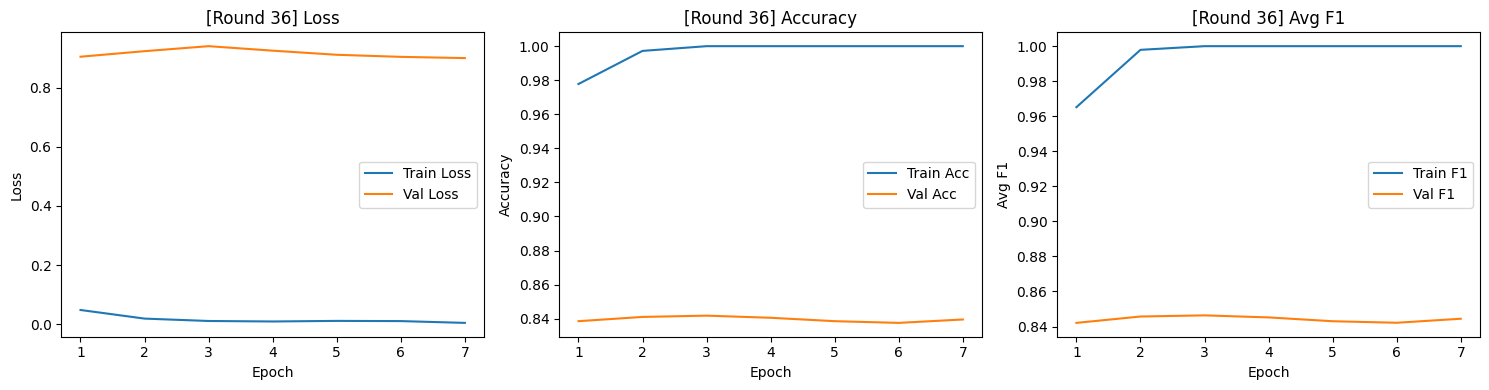


[AL Round 37/60] — Labeled samples: 370

Epoch 1/7


Train — Loss: 0.0420 | Acc: 0.9811 | Avg F1: 0.9693
Val   — Loss: 0.8904 | Acc: 0.8385 | Avg F1: 0.8431

Epoch 2/7


Train — Loss: 0.0235 | Acc: 0.9946 | Avg F1: 0.9920
Val   — Loss: 0.8787 | Acc: 0.8395 | Avg F1: 0.8441

Epoch 3/7


Train — Loss: 0.0137 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8822 | Acc: 0.8403 | Avg F1: 0.8447

Epoch 4/7


Train — Loss: 0.0114 | Acc: 0.9973 | Avg F1: 0.9980
Val   — Loss: 0.8761 | Acc: 0.8395 | Avg F1: 0.8432

Epoch 5/7


Train — Loss: 0.0062 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8710 | Acc: 0.8405 | Avg F1: 0.8438

Epoch 6/7


Train — Loss: 0.0060 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8690 | Acc: 0.8433 | Avg F1: 0.8471

Epoch 7/7


Train — Loss: 0.0065 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8647 | Acc: 0.8420 | Avg F1: 0.8457


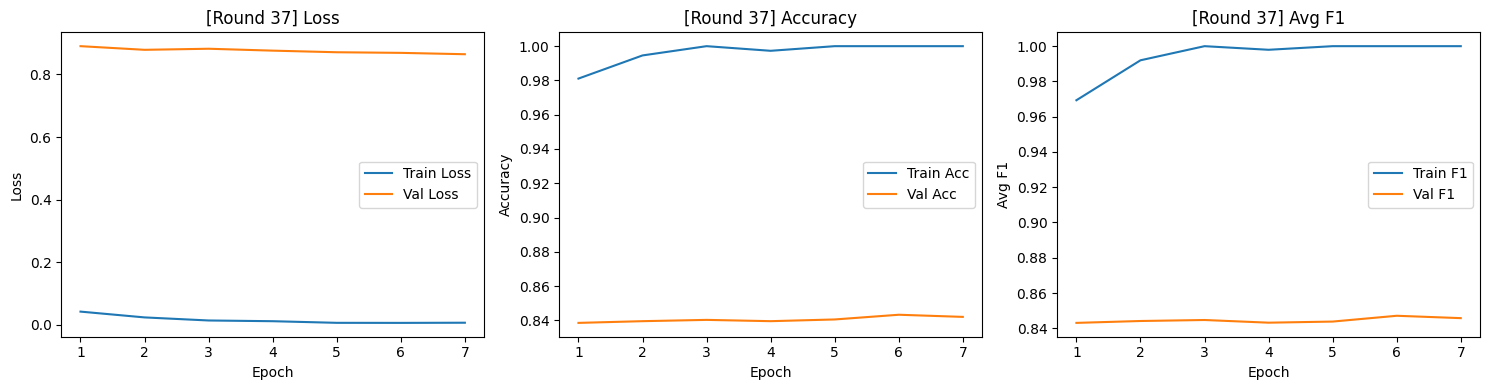


[AL Round 38/60] — Labeled samples: 380

Epoch 1/7


Train — Loss: 0.0469 | Acc: 0.9816 | Avg F1: 0.9782
Val   — Loss: 0.8618 | Acc: 0.8425 | Avg F1: 0.8456

Epoch 2/7


Train — Loss: 0.0351 | Acc: 0.9868 | Avg F1: 0.9900
Val   — Loss: 0.8794 | Acc: 0.8377 | Avg F1: 0.8415

Epoch 3/7


Train — Loss: 0.0087 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8755 | Acc: 0.8333 | Avg F1: 0.8369

Epoch 4/7


Train — Loss: 0.0147 | Acc: 0.9974 | Avg F1: 0.9980
Val   — Loss: 0.8743 | Acc: 0.8335 | Avg F1: 0.8365

Epoch 5/7


Train — Loss: 0.0042 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8753 | Acc: 0.8345 | Avg F1: 0.8382

Epoch 6/7


Train — Loss: 0.0068 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8786 | Acc: 0.8380 | Avg F1: 0.8413

Epoch 7/7


Train — Loss: 0.0041 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8835 | Acc: 0.8417 | Avg F1: 0.8450


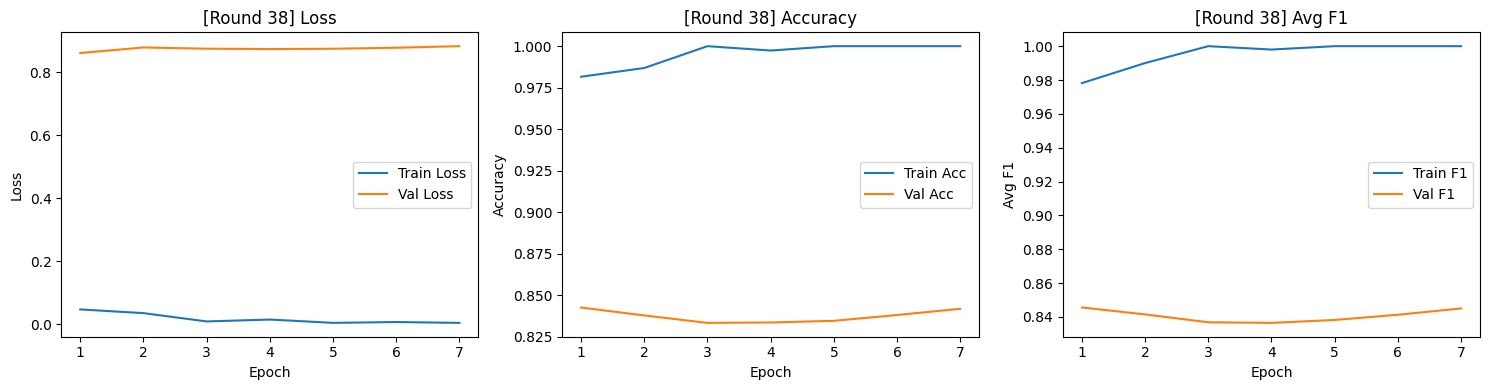


[AL Round 39/60] — Labeled samples: 390

Epoch 1/7


Train — Loss: 0.0377 | Acc: 0.9821 | Avg F1: 0.9792
Val   — Loss: 0.8799 | Acc: 0.8330 | Avg F1: 0.8384

Epoch 2/7


Train — Loss: 0.0388 | Acc: 0.9974 | Avg F1: 0.9981
Val   — Loss: 1.0150 | Acc: 0.8225 | Avg F1: 0.8314

Epoch 3/7


Train — Loss: 0.2051 | Acc: 0.9333 | Avg F1: 0.9454
Val   — Loss: 1.1507 | Acc: 0.7957 | Avg F1: 0.8088

Epoch 4/7


Train — Loss: 0.1383 | Acc: 0.9615 | Avg F1: 0.9671
Val   — Loss: 3.6518 | Acc: 0.5890 | Avg F1: 0.5649

Epoch 5/7


Train — Loss: 0.1253 | Acc: 0.9564 | Avg F1: 0.9672
Val   — Loss: 1.1593 | Acc: 0.7887 | Avg F1: 0.7958

Epoch 6/7


Train — Loss: 0.0766 | Acc: 0.9872 | Avg F1: 0.9903
Val   — Loss: 0.8901 | Acc: 0.8225 | Avg F1: 0.8313

Epoch 7/7


Train — Loss: 0.0739 | Acc: 0.9769 | Avg F1: 0.9753
Val   — Loss: 1.0093 | Acc: 0.8065 | Avg F1: 0.8129


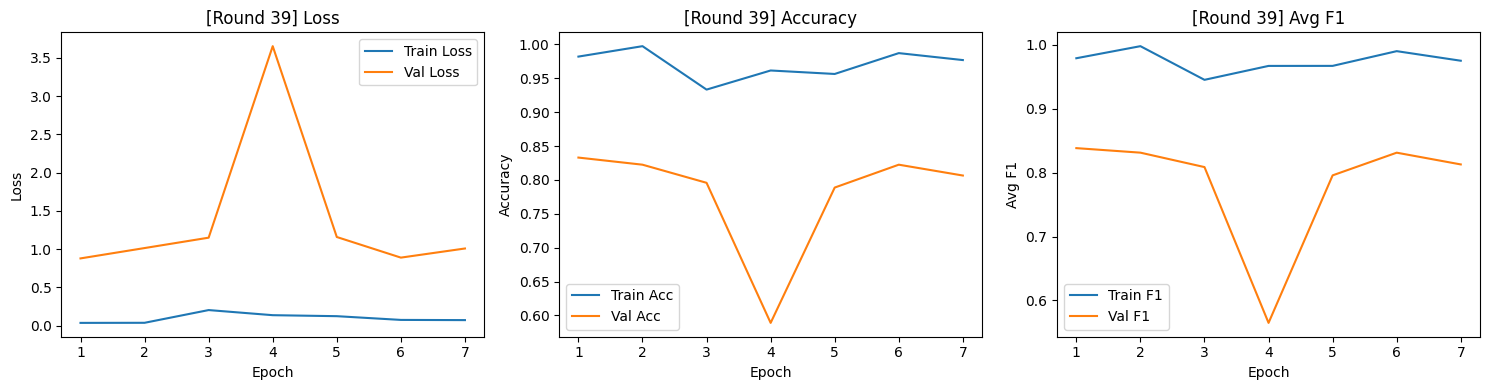


[AL Round 40/60] — Labeled samples: 400

Epoch 1/7


Train — Loss: 0.0972 | Acc: 0.9700 | Avg F1: 0.9662
Val   — Loss: 1.0942 | Acc: 0.7800 | Avg F1: 0.7904

Epoch 2/7


Train — Loss: 0.0677 | Acc: 0.9825 | Avg F1: 0.9797
Val   — Loss: 0.9292 | Acc: 0.8075 | Avg F1: 0.8176

Epoch 3/7


Train — Loss: 0.0405 | Acc: 0.9875 | Avg F1: 0.9865
Val   — Loss: 0.8455 | Acc: 0.8297 | Avg F1: 0.8372

Epoch 4/7


Train — Loss: 0.0275 | Acc: 0.9975 | Avg F1: 0.9942
Val   — Loss: 0.8567 | Acc: 0.8365 | Avg F1: 0.8440

Epoch 5/7


Train — Loss: 0.0234 | Acc: 0.9975 | Avg F1: 0.9942
Val   — Loss: 0.8486 | Acc: 0.8403 | Avg F1: 0.8466

Epoch 6/7


Train — Loss: 0.0217 | Acc: 0.9950 | Avg F1: 0.9922
Val   — Loss: 0.9077 | Acc: 0.8327 | Avg F1: 0.8391

Epoch 7/7


Train — Loss: 0.0130 | Acc: 0.9975 | Avg F1: 0.9981
Val   — Loss: 1.0012 | Acc: 0.8120 | Avg F1: 0.8225


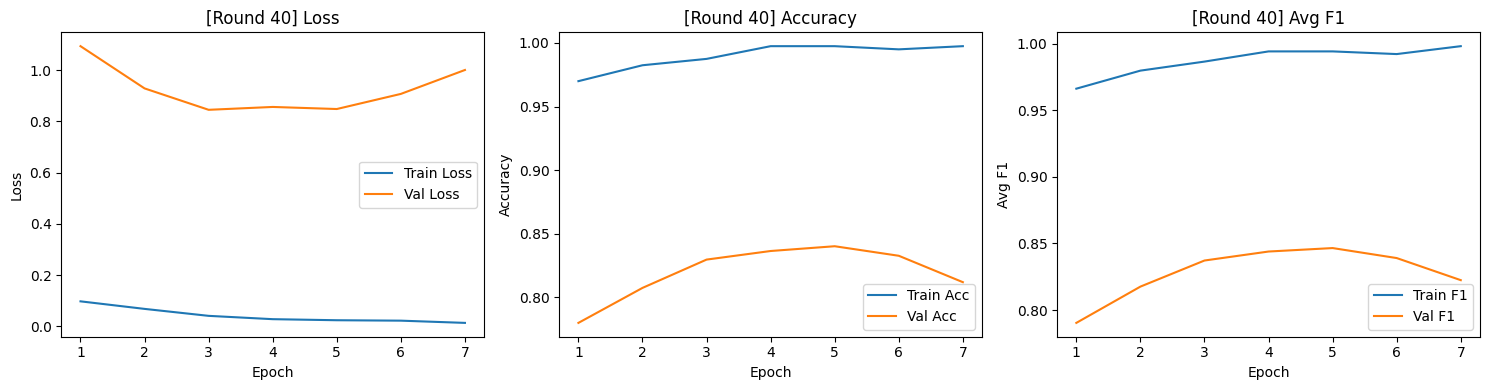


[AL Round 41/60] — Labeled samples: 410

Epoch 1/7


Train — Loss: 0.0784 | Acc: 0.9805 | Avg F1: 0.9742
Val   — Loss: 0.9659 | Acc: 0.8187 | Avg F1: 0.8291

Epoch 2/7


Train — Loss: 0.0124 | Acc: 0.9976 | Avg F1: 0.9982
Val   — Loss: 0.9171 | Acc: 0.8417 | Avg F1: 0.8482

Epoch 3/7


Train — Loss: 0.0109 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9120 | Acc: 0.8458 | Avg F1: 0.8516

Epoch 4/7


Train — Loss: 0.0114 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9092 | Acc: 0.8438 | Avg F1: 0.8498

Epoch 5/7


Train — Loss: 0.0078 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9071 | Acc: 0.8430 | Avg F1: 0.8496

Epoch 6/7


Train — Loss: 0.0102 | Acc: 0.9976 | Avg F1: 0.9943
Val   — Loss: 0.9102 | Acc: 0.8433 | Avg F1: 0.8498

Epoch 7/7


Train — Loss: 0.0068 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9122 | Acc: 0.8413 | Avg F1: 0.8482


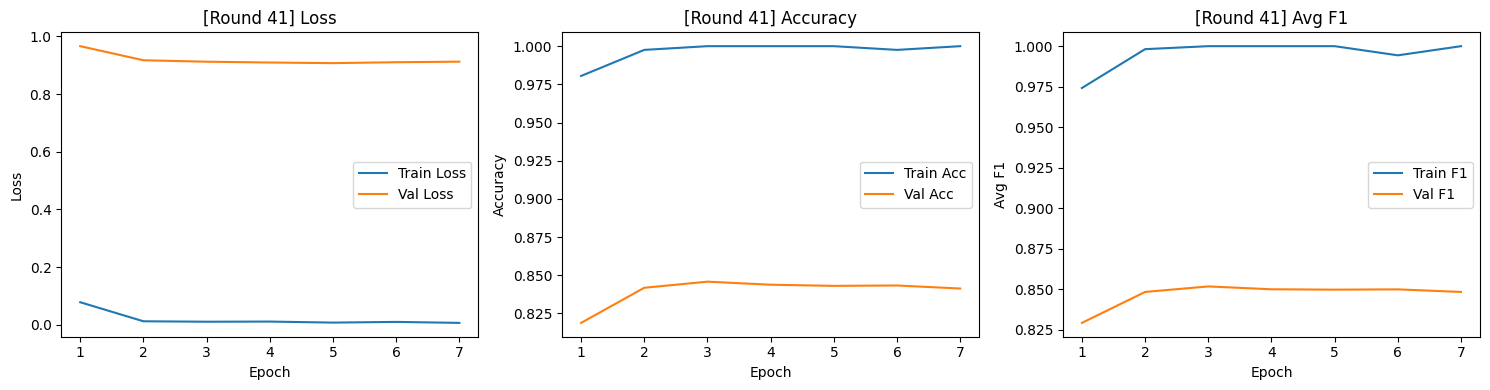


[AL Round 42/60] — Labeled samples: 420

Epoch 1/7


Train — Loss: 0.0346 | Acc: 0.9881 | Avg F1: 0.9877
Val   — Loss: 0.9301 | Acc: 0.8377 | Avg F1: 0.8440

Epoch 2/7


Train — Loss: 0.0193 | Acc: 0.9952 | Avg F1: 0.9964
Val   — Loss: 0.9306 | Acc: 0.8440 | Avg F1: 0.8492

Epoch 3/7


Train — Loss: 0.0073 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9383 | Acc: 0.8488 | Avg F1: 0.8540

Epoch 4/7


Train — Loss: 0.0084 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9400 | Acc: 0.8485 | Avg F1: 0.8539

Epoch 5/7


Train — Loss: 0.0056 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9389 | Acc: 0.8458 | Avg F1: 0.8517

Epoch 6/7


Train — Loss: 0.0078 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9474 | Acc: 0.8430 | Avg F1: 0.8489

Epoch 7/7


Train — Loss: 0.0043 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9411 | Acc: 0.8442 | Avg F1: 0.8502


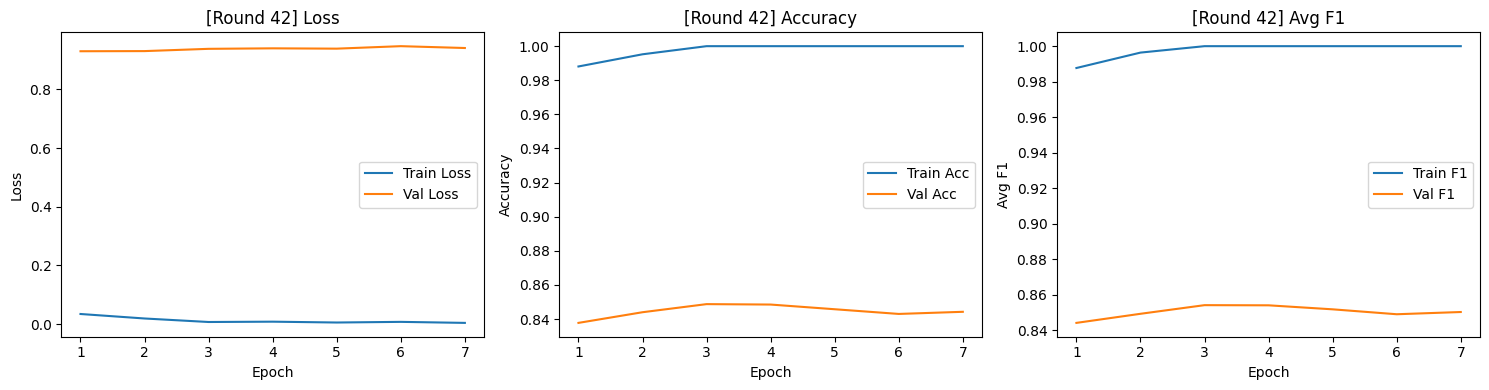


[AL Round 43/60] — Labeled samples: 430

Epoch 1/7


Train — Loss: 0.0340 | Acc: 0.9884 | Avg F1: 0.9844
Val   — Loss: 0.9303 | Acc: 0.8455 | Avg F1: 0.8513

Epoch 2/7


Train — Loss: 0.0230 | Acc: 0.9930 | Avg F1: 0.9912
Val   — Loss: 0.9286 | Acc: 0.8458 | Avg F1: 0.8506

Epoch 3/7


Train — Loss: 0.0097 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9204 | Acc: 0.8445 | Avg F1: 0.8493

Epoch 4/7


Train — Loss: 0.0095 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9099 | Acc: 0.8455 | Avg F1: 0.8498

Epoch 5/7


Train — Loss: 0.0052 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9116 | Acc: 0.8455 | Avg F1: 0.8504

Epoch 6/7


Train — Loss: 0.0035 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9131 | Acc: 0.8450 | Avg F1: 0.8500

Epoch 7/7


Train — Loss: 0.0042 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9116 | Acc: 0.8460 | Avg F1: 0.8510


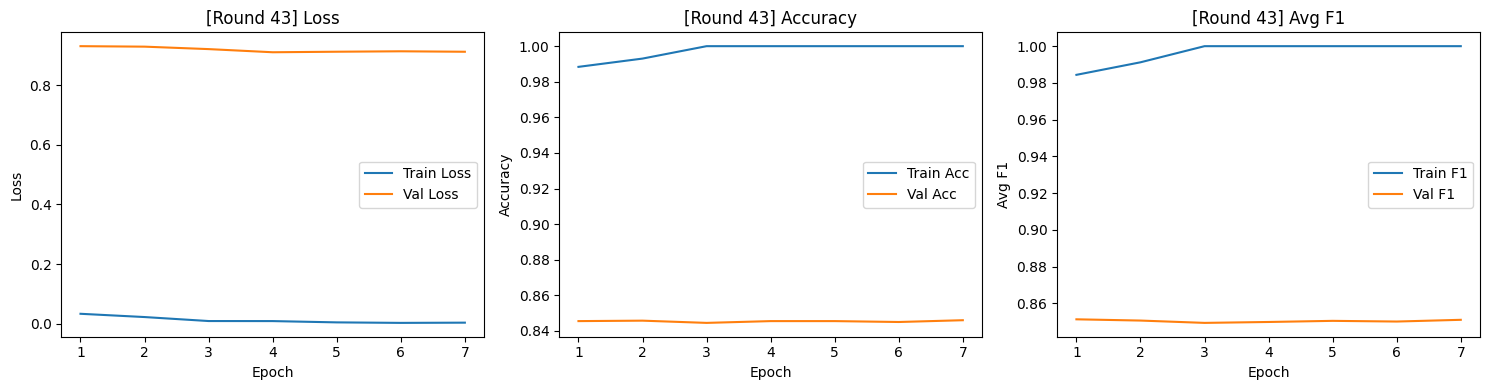


[AL Round 44/60] — Labeled samples: 440

Epoch 1/7


Train — Loss: 0.0302 | Acc: 0.9886 | Avg F1: 0.9824
Val   — Loss: 0.8945 | Acc: 0.8442 | Avg F1: 0.8485

Epoch 2/7


Train — Loss: 0.0155 | Acc: 0.9932 | Avg F1: 0.9913
Val   — Loss: 0.8934 | Acc: 0.8470 | Avg F1: 0.8497

Epoch 3/7


Train — Loss: 0.0115 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8947 | Acc: 0.8462 | Avg F1: 0.8477

Epoch 4/7


Train — Loss: 0.0059 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9014 | Acc: 0.8425 | Avg F1: 0.8438

Epoch 5/7


Train — Loss: 0.0078 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9002 | Acc: 0.8440 | Avg F1: 0.8460

Epoch 6/7


Train — Loss: 0.0046 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9001 | Acc: 0.8438 | Avg F1: 0.8461

Epoch 7/7


Train — Loss: 0.0072 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9059 | Acc: 0.8462 | Avg F1: 0.8497


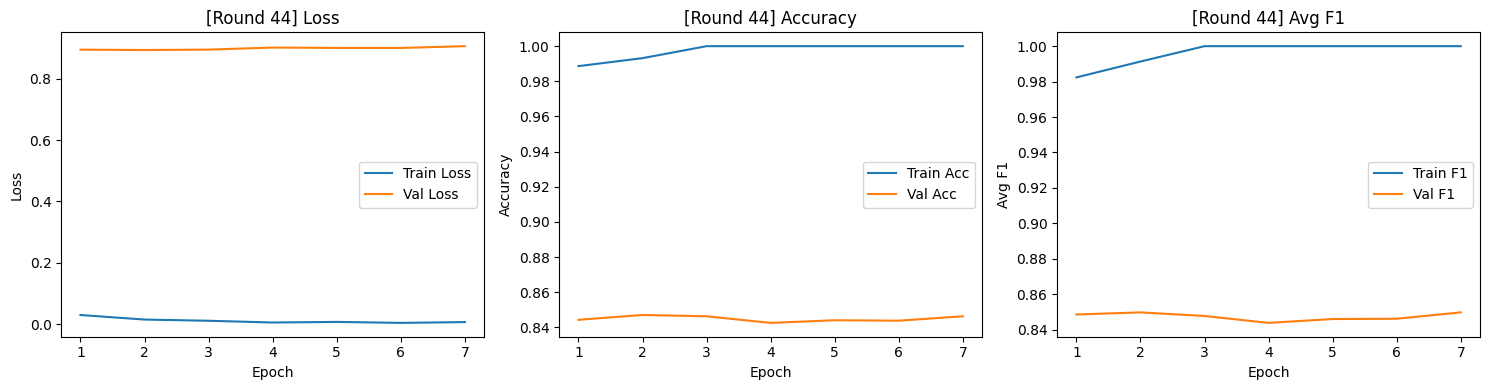


[AL Round 45/60] — Labeled samples: 450

Epoch 1/7


Train — Loss: 0.0383 | Acc: 0.9844 | Avg F1: 0.9815
Val   — Loss: 0.8956 | Acc: 0.8472 | Avg F1: 0.8502

Epoch 2/7


Train — Loss: 0.0173 | Acc: 0.9933 | Avg F1: 0.9885
Val   — Loss: 0.9613 | Acc: 0.8405 | Avg F1: 0.8417

Epoch 3/7


Train — Loss: 0.2503 | Acc: 0.9356 | Avg F1: 0.8860
Val   — Loss: 3.1734 | Acc: 0.5373 | Avg F1: 0.5090

Epoch 4/7


Train — Loss: 0.2154 | Acc: 0.9556 | Avg F1: 0.9154
Val   — Loss: 1.0188 | Acc: 0.8325 | Avg F1: 0.8340

Epoch 5/7


Train — Loss: 0.0694 | Acc: 0.9756 | Avg F1: 0.9658
Val   — Loss: 0.9720 | Acc: 0.8347 | Avg F1: 0.8352

Epoch 6/7


Train — Loss: 0.0448 | Acc: 0.9889 | Avg F1: 0.9819
Val   — Loss: 0.9500 | Acc: 0.8163 | Avg F1: 0.8158

Epoch 7/7


Train — Loss: 0.0314 | Acc: 0.9911 | Avg F1: 0.9899
Val   — Loss: 0.9559 | Acc: 0.8290 | Avg F1: 0.8313


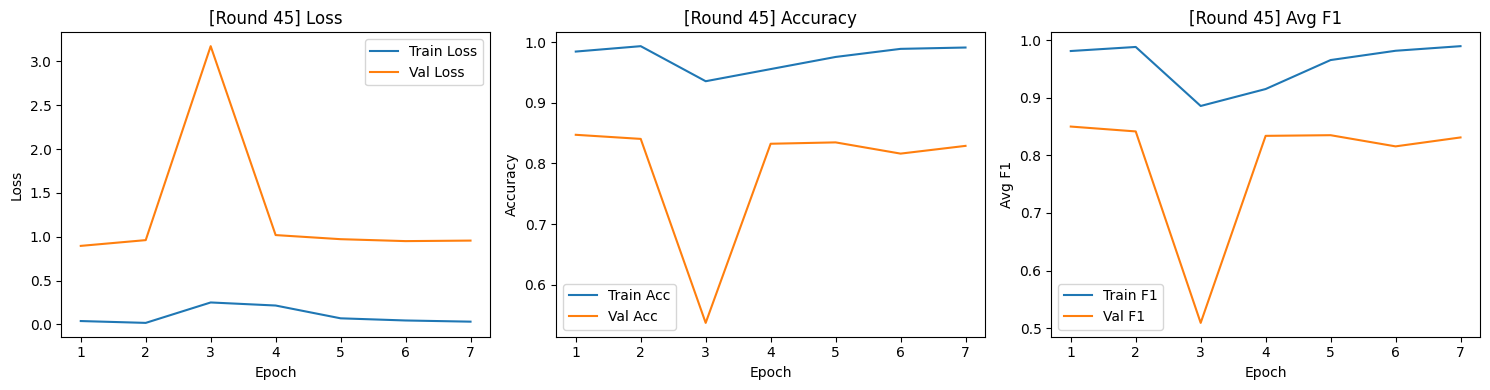


[AL Round 46/60] — Labeled samples: 460

Epoch 1/7


Train — Loss: 0.0497 | Acc: 0.9848 | Avg F1: 0.9820
Val   — Loss: 0.9138 | Acc: 0.8385 | Avg F1: 0.8422

Epoch 2/7


Train — Loss: 0.0134 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9262 | Acc: 0.8325 | Avg F1: 0.8380

Epoch 3/7


Train — Loss: 0.0174 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9255 | Acc: 0.8307 | Avg F1: 0.8366

Epoch 4/7


Train — Loss: 0.0087 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8890 | Acc: 0.8375 | Avg F1: 0.8420

Epoch 5/7


Train — Loss: 0.0136 | Acc: 0.9978 | Avg F1: 0.9984
Val   — Loss: 0.9025 | Acc: 0.8365 | Avg F1: 0.8404

Epoch 6/7


Train — Loss: 0.0065 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9394 | Acc: 0.8317 | Avg F1: 0.8357

Epoch 7/7


Train — Loss: 0.0062 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9744 | Acc: 0.8273 | Avg F1: 0.8311


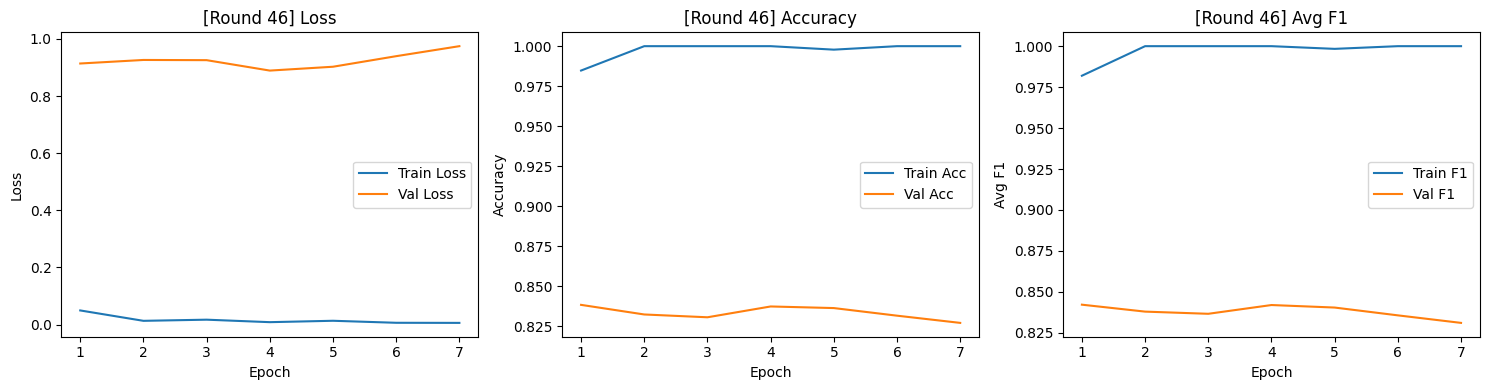


[AL Round 47/60] — Labeled samples: 470

Epoch 1/7


Train — Loss: 0.0291 | Acc: 0.9894 | Avg F1: 0.9830
Val   — Loss: 0.9940 | Acc: 0.8333 | Avg F1: 0.8375

Epoch 2/7


Train — Loss: 0.0295 | Acc: 0.9872 | Avg F1: 0.9904
Val   — Loss: 0.9425 | Acc: 0.8445 | Avg F1: 0.8482

Epoch 3/7


Train — Loss: 0.0175 | Acc: 0.9957 | Avg F1: 0.9939
Val   — Loss: 0.9238 | Acc: 0.8423 | Avg F1: 0.8459

Epoch 4/7


Train — Loss: 0.0147 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9113 | Acc: 0.8460 | Avg F1: 0.8496

Epoch 5/7


Train — Loss: 0.0072 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9083 | Acc: 0.8510 | Avg F1: 0.8539

Epoch 6/7


Train — Loss: 0.0079 | Acc: 0.9979 | Avg F1: 0.9984
Val   — Loss: 0.9143 | Acc: 0.8470 | Avg F1: 0.8489

Epoch 7/7


Train — Loss: 0.0157 | Acc: 0.9979 | Avg F1: 0.9984
Val   — Loss: 0.8890 | Acc: 0.8480 | Avg F1: 0.8529


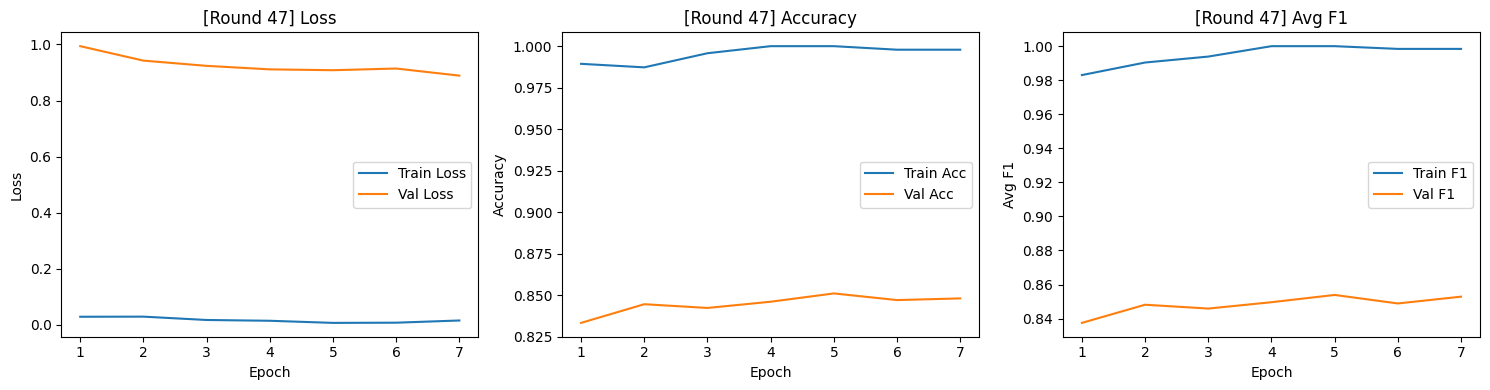


[AL Round 48/60] — Labeled samples: 480

Epoch 1/7


Train — Loss: 0.0319 | Acc: 0.9896 | Avg F1: 0.9863
Val   — Loss: 0.9000 | Acc: 0.8435 | Avg F1: 0.8491

Epoch 2/7


Train — Loss: 0.0155 | Acc: 0.9979 | Avg F1: 0.9984
Val   — Loss: 0.9248 | Acc: 0.8430 | Avg F1: 0.8492

Epoch 3/7


Train — Loss: 0.0136 | Acc: 0.9958 | Avg F1: 0.9942
Val   — Loss: 0.9324 | Acc: 0.8458 | Avg F1: 0.8516

Epoch 4/7


Train — Loss: 0.0065 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9295 | Acc: 0.8468 | Avg F1: 0.8516

Epoch 5/7


Train — Loss: 0.0064 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9383 | Acc: 0.8438 | Avg F1: 0.8494

Epoch 6/7


Train — Loss: 0.0042 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9341 | Acc: 0.8440 | Avg F1: 0.8507

Epoch 7/7


Train — Loss: 0.0095 | Acc: 0.9979 | Avg F1: 0.9954
Val   — Loss: 0.9297 | Acc: 0.8440 | Avg F1: 0.8494


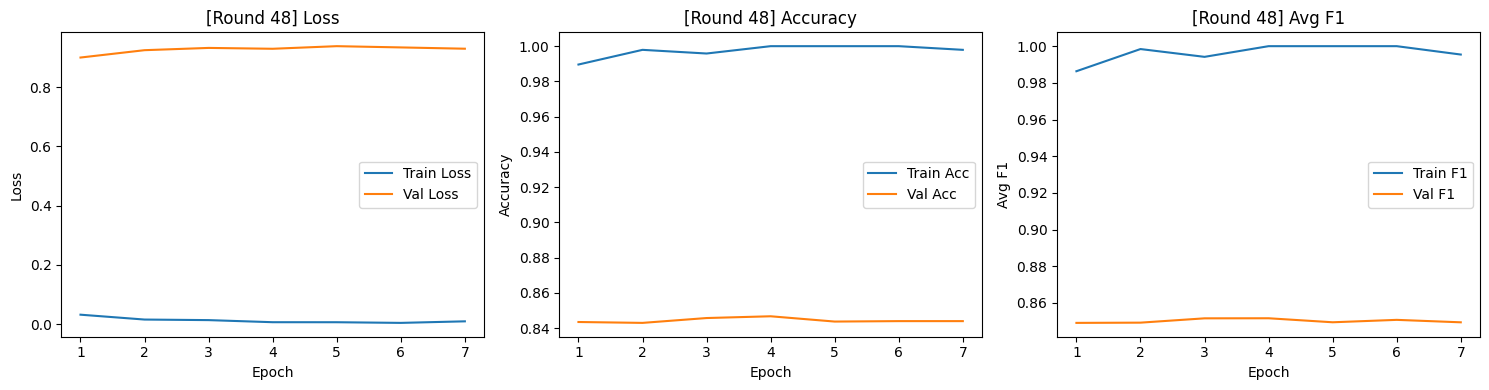


[AL Round 49/60] — Labeled samples: 490

Epoch 1/7


Train — Loss: 0.0380 | Acc: 0.9837 | Avg F1: 0.9769
Val   — Loss: 0.9313 | Acc: 0.8510 | Avg F1: 0.8544

Epoch 2/7


Train — Loss: 0.0085 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9690 | Acc: 0.8452 | Avg F1: 0.8498

Epoch 3/7


Train — Loss: 0.0159 | Acc: 0.9980 | Avg F1: 0.9985
Val   — Loss: 0.9530 | Acc: 0.8512 | Avg F1: 0.8546

Epoch 4/7


Train — Loss: 0.0059 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9528 | Acc: 0.8455 | Avg F1: 0.8508

Epoch 5/7


Train — Loss: 0.0124 | Acc: 0.9980 | Avg F1: 0.9985
Val   — Loss: 0.9607 | Acc: 0.8462 | Avg F1: 0.8516

Epoch 6/7


Train — Loss: 0.0043 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9610 | Acc: 0.8455 | Avg F1: 0.8502

Epoch 7/7


Train — Loss: 0.0029 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9568 | Acc: 0.8472 | Avg F1: 0.8513


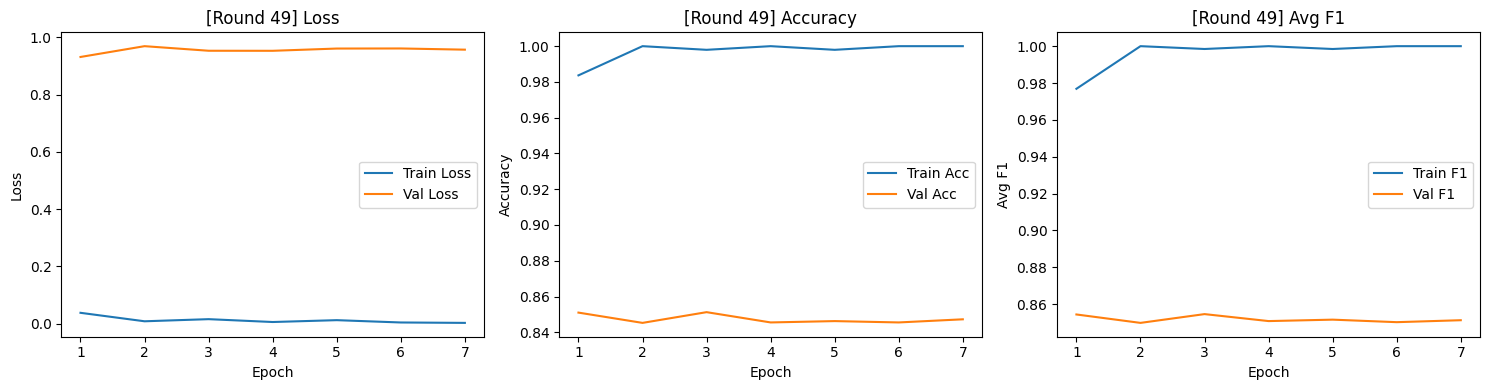


[AL Round 50/60] — Labeled samples: 500

Epoch 1/7


Train — Loss: 0.0260 | Acc: 0.9900 | Avg F1: 0.9898
Val   — Loss: 0.9682 | Acc: 0.8490 | Avg F1: 0.8537

Epoch 2/7


Train — Loss: 0.0195 | Acc: 0.9900 | Avg F1: 0.9896
Val   — Loss: 0.9863 | Acc: 0.8495 | Avg F1: 0.8548

Epoch 3/7


Train — Loss: 0.0049 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0003 | Acc: 0.8480 | Avg F1: 0.8533

Epoch 4/7


Train — Loss: 0.0080 | Acc: 0.9980 | Avg F1: 0.9985
Val   — Loss: 0.9913 | Acc: 0.8495 | Avg F1: 0.8539

Epoch 5/7


Train — Loss: 0.0054 | Acc: 0.9980 | Avg F1: 0.9985
Val   — Loss: 0.9813 | Acc: 0.8510 | Avg F1: 0.8558

Epoch 6/7


Train — Loss: 0.0026 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9807 | Acc: 0.8522 | Avg F1: 0.8567

Epoch 7/7


Train — Loss: 0.0026 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9741 | Acc: 0.8538 | Avg F1: 0.8579


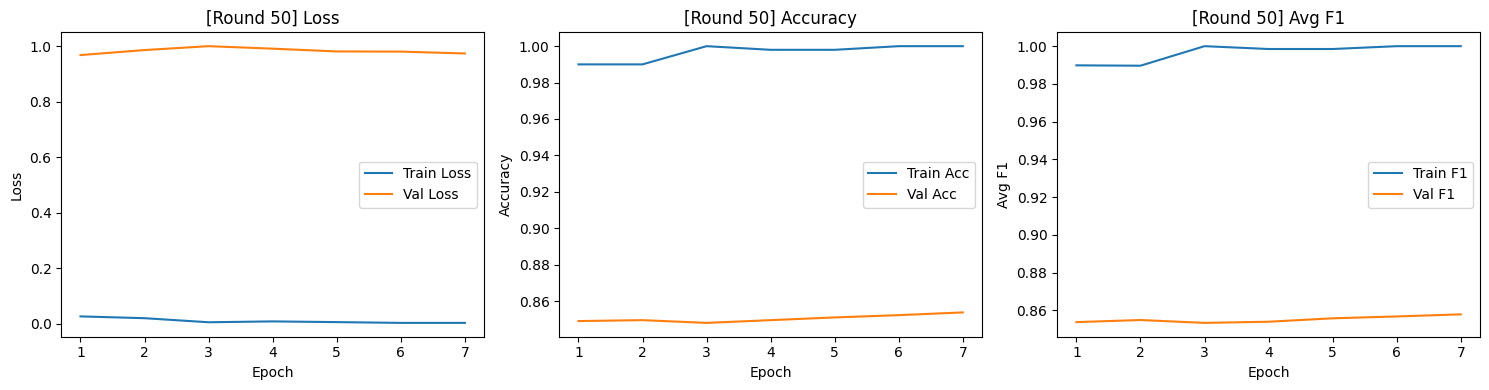


[AL Round 51/60] — Labeled samples: 510

Epoch 1/7


Train — Loss: 0.0368 | Acc: 0.9863 | Avg F1: 0.9791
Val   — Loss: 1.0440 | Acc: 0.8395 | Avg F1: 0.8455

Epoch 2/7


Train — Loss: 0.0168 | Acc: 0.9922 | Avg F1: 0.9861
Val   — Loss: 1.1323 | Acc: 0.8257 | Avg F1: 0.8327

Epoch 3/7


Train — Loss: 0.0138 | Acc: 0.9941 | Avg F1: 0.9928
Val   — Loss: 1.0252 | Acc: 0.8512 | Avg F1: 0.8562

Epoch 4/7


Train — Loss: 0.0080 | Acc: 0.9980 | Avg F1: 0.9958
Val   — Loss: 1.0073 | Acc: 0.8525 | Avg F1: 0.8571

Epoch 5/7


Train — Loss: 0.0048 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9929 | Acc: 0.8550 | Avg F1: 0.8600

Epoch 6/7


Train — Loss: 0.0033 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9876 | Acc: 0.8532 | Avg F1: 0.8582

Epoch 7/7


Train — Loss: 0.0028 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9879 | Acc: 0.8502 | Avg F1: 0.8544


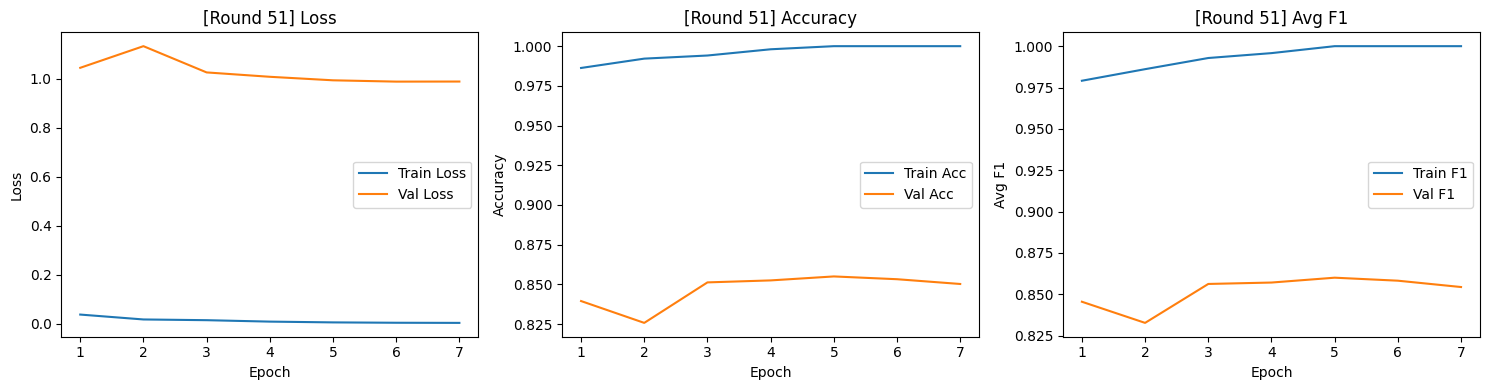


[AL Round 52/60] — Labeled samples: 520

Epoch 1/7


Train — Loss: 0.0231 | Acc: 0.9885 | Avg F1: 0.9862
Val   — Loss: 0.9650 | Acc: 0.8510 | Avg F1: 0.8566

Epoch 2/7


Train — Loss: 0.0068 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9819 | Acc: 0.8472 | Avg F1: 0.8530

Epoch 3/7


Train — Loss: 0.0287 | Acc: 0.9885 | Avg F1: 0.9913
Val   — Loss: 0.9223 | Acc: 0.8560 | Avg F1: 0.8589

Epoch 4/7


Train — Loss: 0.0123 | Acc: 0.9981 | Avg F1: 0.9986
Val   — Loss: 0.9043 | Acc: 0.8417 | Avg F1: 0.8469

Epoch 5/7


Train — Loss: 0.0533 | Acc: 0.9846 | Avg F1: 0.9860
Val   — Loss: 1.1026 | Acc: 0.8175 | Avg F1: 0.8164

Epoch 6/7


Train — Loss: 0.0413 | Acc: 0.9827 | Avg F1: 0.9790
Val   — Loss: 1.2843 | Acc: 0.8205 | Avg F1: 0.8189

Epoch 7/7


Train — Loss: 0.1312 | Acc: 0.9558 | Avg F1: 0.9527
Val   — Loss: 1.1582 | Acc: 0.8413 | Avg F1: 0.8459


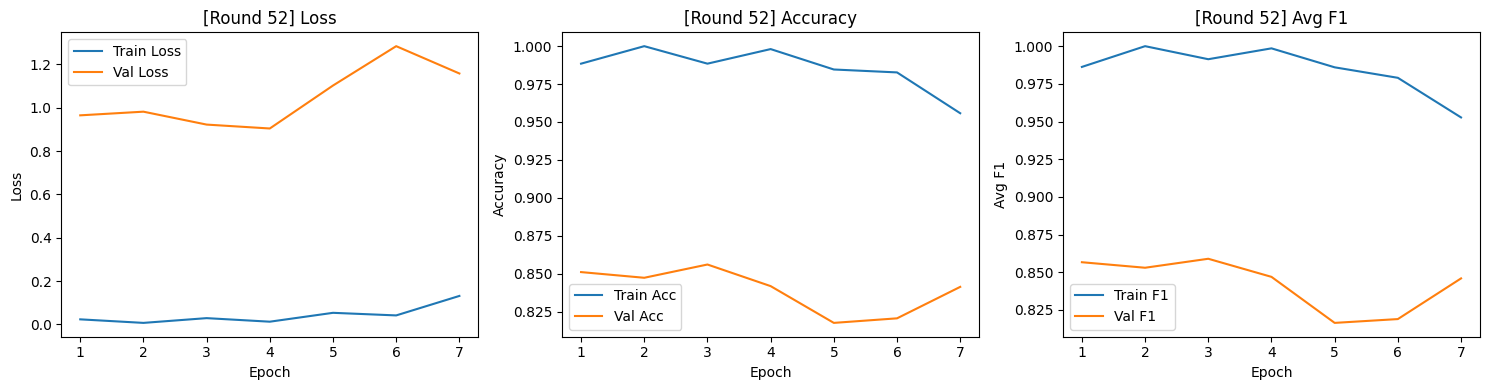


[AL Round 53/60] — Labeled samples: 530

Epoch 1/7


Train — Loss: 0.1570 | Acc: 0.9566 | Avg F1: 0.9457
Val   — Loss: 1.1939 | Acc: 0.8370 | Avg F1: 0.8436

Epoch 2/7


Train — Loss: 0.0725 | Acc: 0.9755 | Avg F1: 0.9625
Val   — Loss: 1.0438 | Acc: 0.8425 | Avg F1: 0.8482

Epoch 3/7


Train — Loss: 0.0456 | Acc: 0.9868 | Avg F1: 0.9824
Val   — Loss: 1.0793 | Acc: 0.8305 | Avg F1: 0.8382

Epoch 4/7


Train — Loss: 0.0365 | Acc: 0.9943 | Avg F1: 0.9933
Val   — Loss: 0.9957 | Acc: 0.8405 | Avg F1: 0.8476

Epoch 5/7


Train — Loss: 0.0206 | Acc: 0.9962 | Avg F1: 0.9972
Val   — Loss: 0.9919 | Acc: 0.8345 | Avg F1: 0.8423

Epoch 6/7


Train — Loss: 0.0183 | Acc: 0.9962 | Avg F1: 0.9946
Val   — Loss: 0.9573 | Acc: 0.8512 | Avg F1: 0.8572

Epoch 7/7


Train — Loss: 0.0088 | Acc: 0.9981 | Avg F1: 0.9986
Val   — Loss: 0.9711 | Acc: 0.8452 | Avg F1: 0.8516


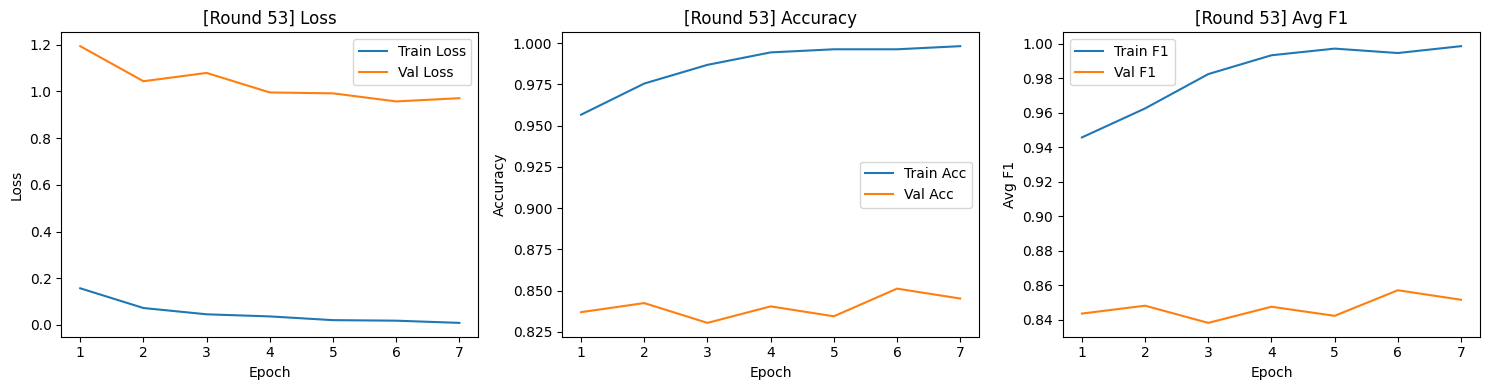


[AL Round 54/60] — Labeled samples: 540

Epoch 1/7


Train — Loss: 0.0314 | Acc: 0.9889 | Avg F1: 0.9868
Val   — Loss: 1.0172 | Acc: 0.8377 | Avg F1: 0.8445

Epoch 2/7


Train — Loss: 0.0129 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0057 | Acc: 0.8317 | Avg F1: 0.8403

Epoch 3/7


Train — Loss: 0.0066 | Acc: 0.9981 | Avg F1: 0.9961
Val   — Loss: 0.9618 | Acc: 0.8383 | Avg F1: 0.8452

Epoch 4/7


Train — Loss: 0.0049 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9412 | Acc: 0.8430 | Avg F1: 0.8491

Epoch 5/7


Train — Loss: 0.0036 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9310 | Acc: 0.8462 | Avg F1: 0.8514

Epoch 6/7


Train — Loss: 0.0032 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9355 | Acc: 0.8478 | Avg F1: 0.8530

Epoch 7/7


Train — Loss: 0.0036 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9349 | Acc: 0.8470 | Avg F1: 0.8518


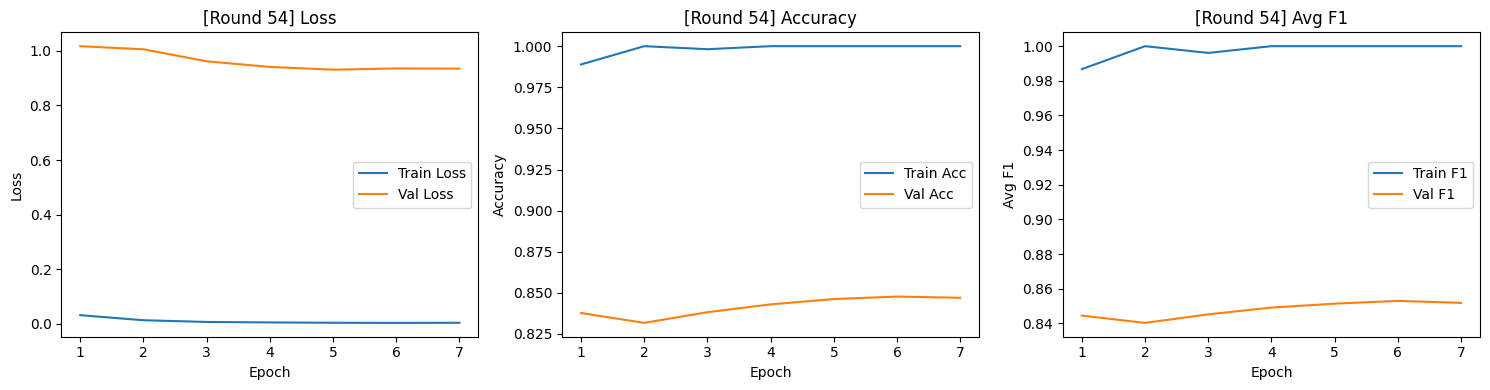


[AL Round 55/60] — Labeled samples: 550

Epoch 1/7


Train — Loss: 0.0240 | Acc: 0.9927 | Avg F1: 0.9923
Val   — Loss: 0.9309 | Acc: 0.8505 | Avg F1: 0.8546

Epoch 2/7


Train — Loss: 0.0163 | Acc: 0.9964 | Avg F1: 0.9973
Val   — Loss: 0.9489 | Acc: 0.8482 | Avg F1: 0.8530

Epoch 3/7


Train — Loss: 0.0058 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9687 | Acc: 0.8415 | Avg F1: 0.8479

Epoch 4/7


Train — Loss: 0.0045 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9700 | Acc: 0.8403 | Avg F1: 0.8471

Epoch 5/7


Train — Loss: 0.0039 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9833 | Acc: 0.8420 | Avg F1: 0.8485

Epoch 6/7


Train — Loss: 0.0026 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9817 | Acc: 0.8417 | Avg F1: 0.8483

Epoch 7/7


Train — Loss: 0.0025 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9844 | Acc: 0.8435 | Avg F1: 0.8499


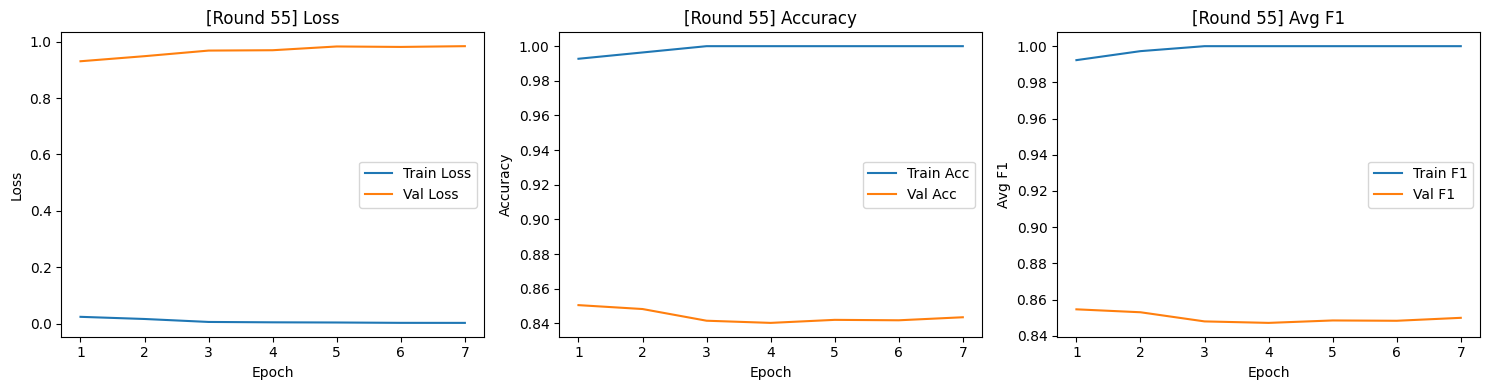


[AL Round 56/60] — Labeled samples: 560

Epoch 1/7


Train — Loss: 0.0328 | Acc: 0.9839 | Avg F1: 0.9833
Val   — Loss: 1.0089 | Acc: 0.8307 | Avg F1: 0.8392

Epoch 2/7


Train — Loss: 0.0042 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9436 | Acc: 0.8458 | Avg F1: 0.8521

Epoch 3/7


Train — Loss: 0.0066 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9372 | Acc: 0.8490 | Avg F1: 0.8535

Epoch 4/7


Train — Loss: 0.0027 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9376 | Acc: 0.8492 | Avg F1: 0.8538

Epoch 5/7


Train — Loss: 0.0039 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9409 | Acc: 0.8492 | Avg F1: 0.8535

Epoch 6/7


Train — Loss: 0.0025 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9495 | Acc: 0.8508 | Avg F1: 0.8547

Epoch 7/7


Train — Loss: 0.0041 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9447 | Acc: 0.8508 | Avg F1: 0.8547


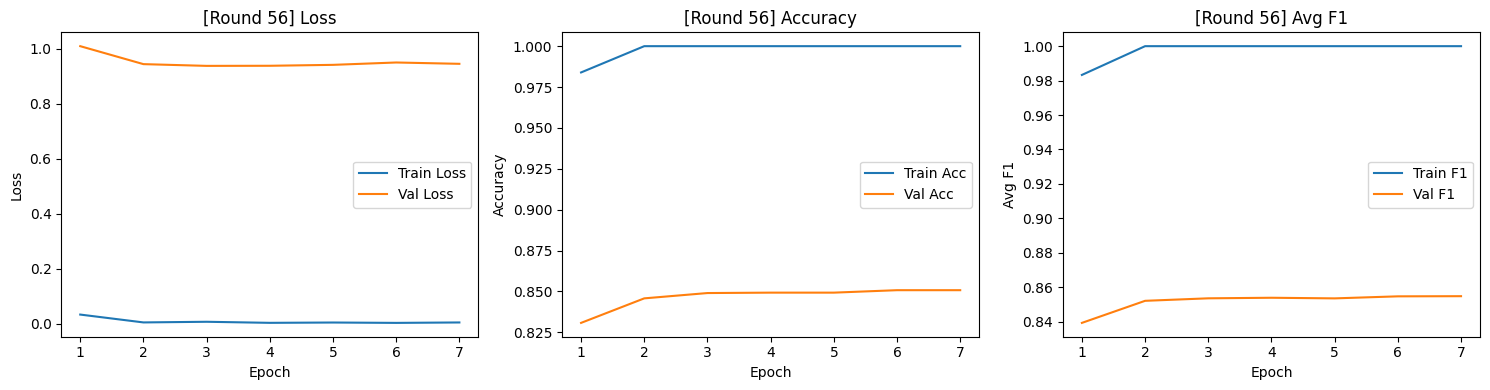


[AL Round 57/60] — Labeled samples: 570

Epoch 1/7


Train — Loss: 0.0140 | Acc: 0.9947 | Avg F1: 0.9960
Val   — Loss: 0.9699 | Acc: 0.8510 | Avg F1: 0.8558

Epoch 2/7


Train — Loss: 0.0063 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9828 | Acc: 0.8508 | Avg F1: 0.8558

Epoch 3/7


Train — Loss: 0.0048 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0075 | Acc: 0.8510 | Avg F1: 0.8559

Epoch 4/7


Train — Loss: 0.0035 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 1.0113 | Acc: 0.8505 | Avg F1: 0.8558

Epoch 5/7


Train — Loss: 0.0064 | Acc: 0.9982 | Avg F1: 0.9987
Val   — Loss: 0.9837 | Acc: 0.8535 | Avg F1: 0.8584

Epoch 6/7


Train — Loss: 0.0025 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9854 | Acc: 0.8522 | Avg F1: 0.8572

Epoch 7/7


Train — Loss: 0.0049 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.9881 | Acc: 0.8515 | Avg F1: 0.8572


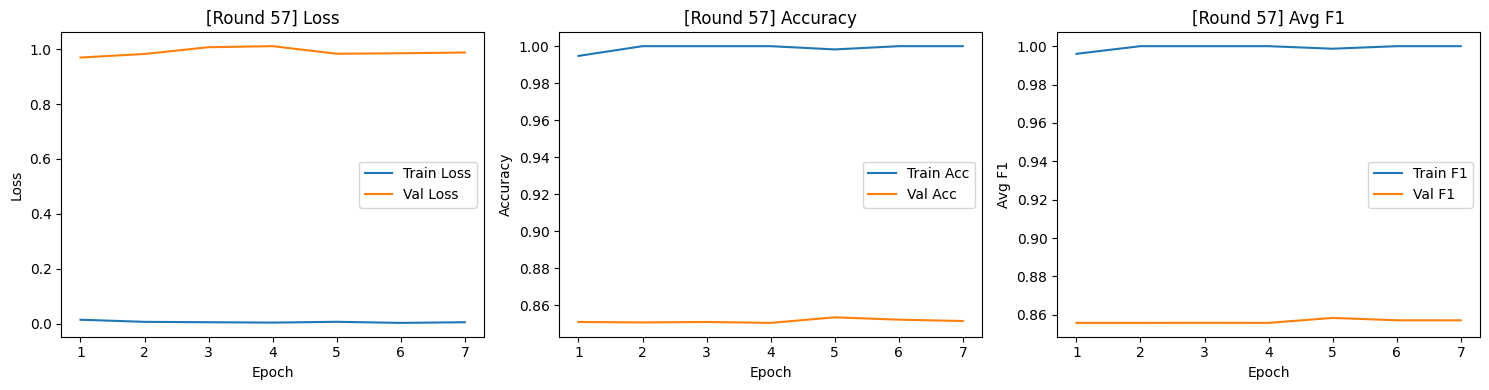


[AL Round 58/60] — Labeled samples: 580

Epoch 1/7


Train — Loss: 0.0334 | Acc: 0.9914 | Avg F1: 0.9914
Val   — Loss: 1.0258 | Acc: 0.8465 | Avg F1: 0.8527

Epoch 2/7


Train — Loss: 0.1158 | Acc: 0.9759 | Avg F1: 0.9625
Val   — Loss: 1.1219 | Acc: 0.8407 | Avg F1: 0.8462

Epoch 3/7


Train — Loss: 0.1696 | Acc: 0.9466 | Avg F1: 0.9410
Val   — Loss: 1.5598 | Acc: 0.7718 | Avg F1: 0.7848

Epoch 4/7


Train — Loss: 0.4323 | Acc: 0.8914 | Avg F1: 0.9051
Val   — Loss: 1.4310 | Acc: 0.7662 | Avg F1: 0.7801

Epoch 5/7


Train — Loss: 0.2233 | Acc: 0.9397 | Avg F1: 0.9412
Val   — Loss: 1.9697 | Acc: 0.7425 | Avg F1: 0.7606

Epoch 6/7


Train — Loss: 0.2840 | Acc: 0.9276 | Avg F1: 0.9369
Val   — Loss: 1.0563 | Acc: 0.8310 | Avg F1: 0.8387

Epoch 7/7


Train — Loss: 0.1486 | Acc: 0.9466 | Avg F1: 0.9557
Val   — Loss: 0.9052 | Acc: 0.8425 | Avg F1: 0.8484


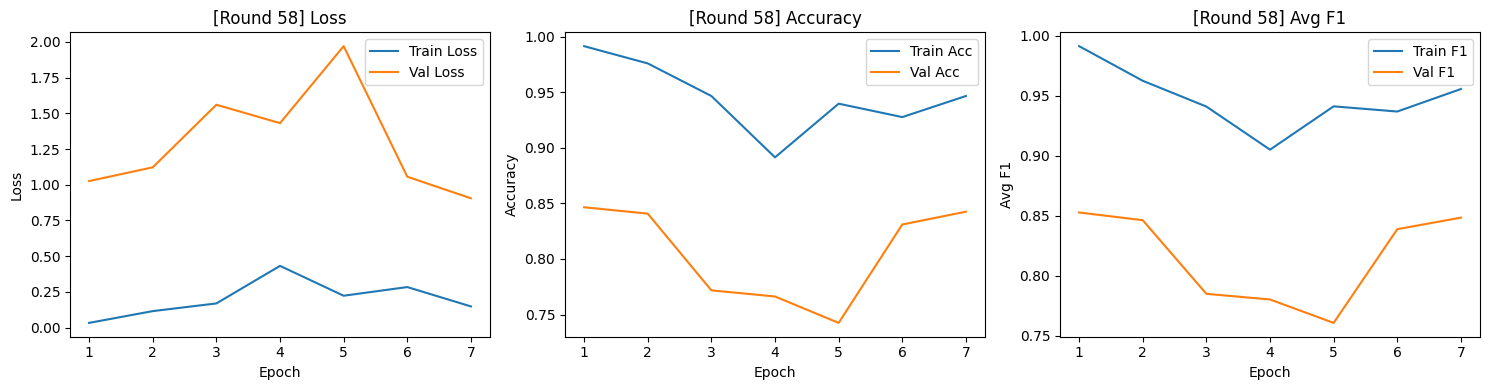


[AL Round 59/60] — Labeled samples: 590

Epoch 1/7


Train — Loss: 0.1315 | Acc: 0.9542 | Avg F1: 0.9527
Val   — Loss: 0.7928 | Acc: 0.8510 | Avg F1: 0.8521

Epoch 2/7


Train — Loss: 0.0603 | Acc: 0.9797 | Avg F1: 0.9825
Val   — Loss: 0.8077 | Acc: 0.8442 | Avg F1: 0.8487

Epoch 3/7


Train — Loss: 0.0243 | Acc: 0.9949 | Avg F1: 0.9941
Val   — Loss: 0.8031 | Acc: 0.8502 | Avg F1: 0.8537

Epoch 4/7


Train — Loss: 0.0279 | Acc: 0.9932 | Avg F1: 0.9907
Val   — Loss: 0.8375 | Acc: 0.8475 | Avg F1: 0.8506

Epoch 5/7


Train — Loss: 0.0233 | Acc: 0.9949 | Avg F1: 0.9900
Val   — Loss: 0.8341 | Acc: 0.8475 | Avg F1: 0.8521

Epoch 6/7


Train — Loss: 0.0122 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8193 | Acc: 0.8495 | Avg F1: 0.8531

Epoch 7/7


Train — Loss: 0.0130 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.8171 | Acc: 0.8510 | Avg F1: 0.8540


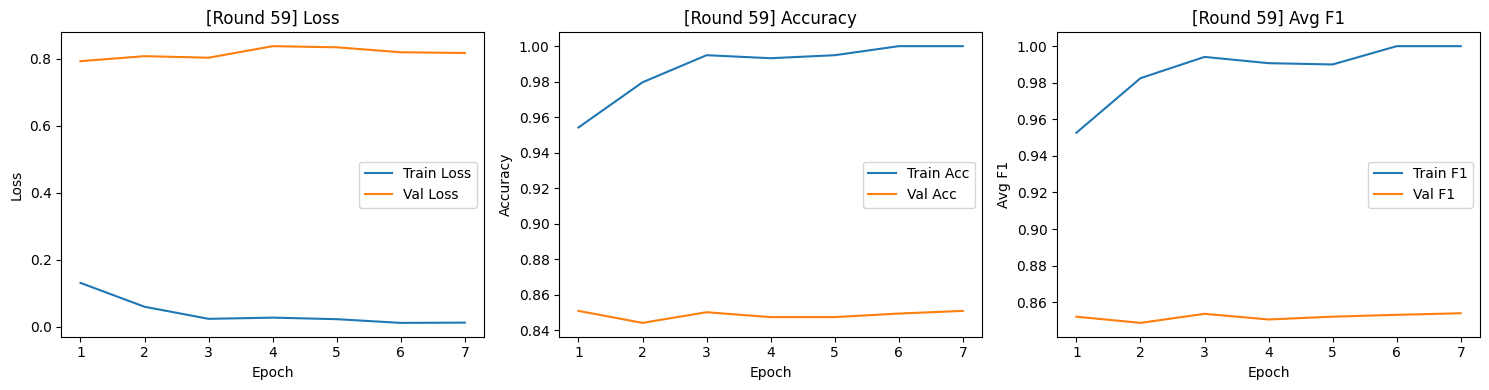


[AL Round 60/60] — Labeled samples: 600

Epoch 1/7


Train — Loss: 0.0405 | Acc: 0.9817 | Avg F1: 0.9724
Val   — Loss: 0.8049 | Acc: 0.8502 | Avg F1: 0.8537

Epoch 2/7


Train — Loss: 0.0177 | Acc: 0.9967 | Avg F1: 0.9955
Val   — Loss: 0.8235 | Acc: 0.8420 | Avg F1: 0.8449

Epoch 3/7


Train — Loss: 0.0149 | Acc: 0.9983 | Avg F1: 0.9969
Val   — Loss: 0.8020 | Acc: 0.8415 | Avg F1: 0.8439

Epoch 4/7


Train — Loss: 0.0073 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.7916 | Acc: 0.8410 | Avg F1: 0.8447

Epoch 5/7


Train — Loss: 0.0102 | Acc: 0.9967 | Avg F1: 0.9975
Val   — Loss: 0.7807 | Acc: 0.8405 | Avg F1: 0.8445

Epoch 6/7


Train — Loss: 0.0056 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.7779 | Acc: 0.8427 | Avg F1: 0.8461

Epoch 7/7


Train — Loss: 0.0045 | Acc: 1.0000 | Avg F1: 1.0000
Val   — Loss: 0.7784 | Acc: 0.8455 | Avg F1: 0.8487


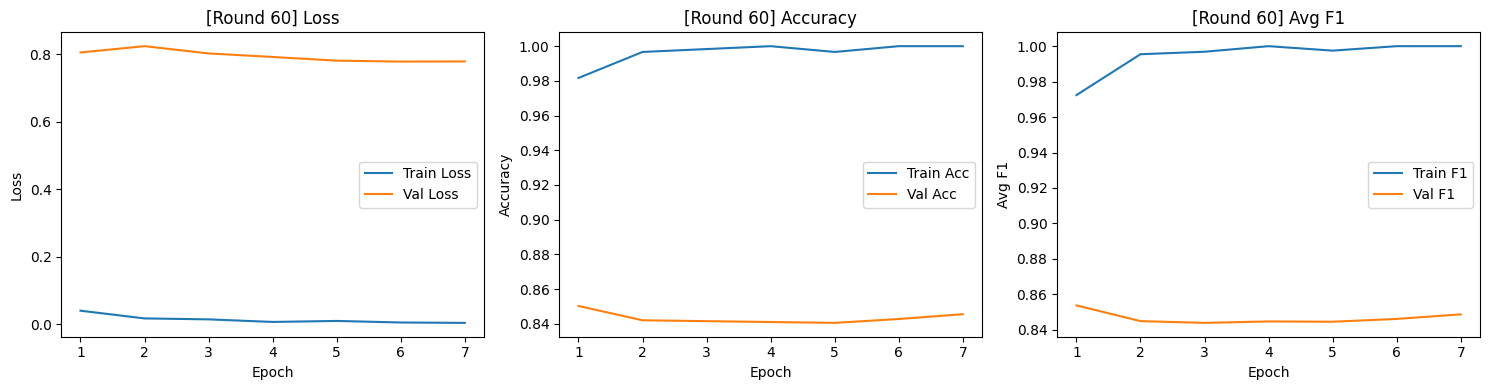

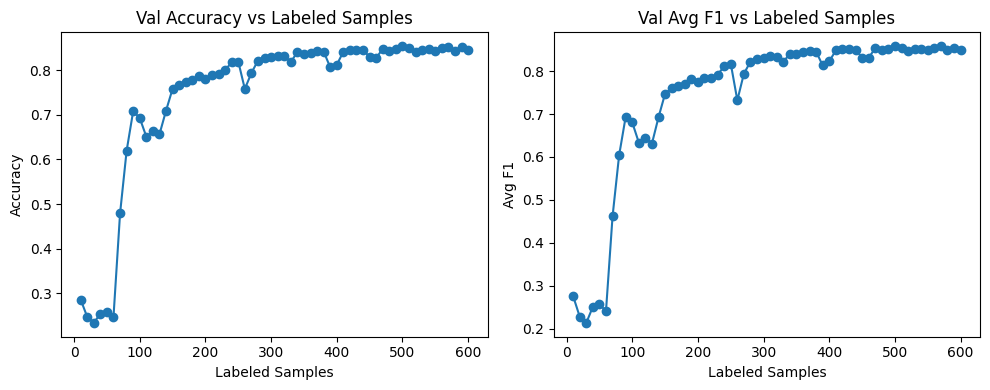

In [170]:
history = active_learning_loop(model, labeled_dataset, unlabeled_dataset, val_dataset, strategy="entropy", device=device, iters=60, query_size=10, epochs=7)

with open("/kaggle/working/history_entropy.pkl", "wb") as f:
    pickle.dump(history, f)
